# 予測値分布の可視化

アテンション位置（共通部分 vs 置換部分）× 分子タイプ（REF vs PRB）× 真のラベル（Bioisostere vs Non-Bioisostere）で予測値の分布を可視化します。

## カテゴリの定義
1. **Bioisostere_REF_Common**: BioisostereペアのREF分子で、共通部分に最大アテンション
2. **Bioisostere_REF_Substituted**: BioisostereペアのREF分子で、置換部分に最大アテンション
3. **Bioisostere_PRB_Common**: BioisostereペアのPRB分子で、共通部分に最大アテンション
4. **Bioisostere_PRB_Substituted**: BioisostereペアのPRB分子で、置換部分に最大アテンション
5. **NonBioisostere_REF_Common**: Non-BioisostereペアのREF分子で、共通部分に最大アテンション
6. **NonBioisostere_REF_Substituted**: Non-BioisostereペアのREF分子で、置換部分に最大アテンション
7. **NonBioisostere_PRB_Common**: Non-BioisostereペアのPRB分子で、共通部分に最大アテンション
8. **NonBioisostere_PRB_Substituted**: Non-BioisostereペアのPRB分子で、置換部分に最大アテンション

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 日本語フォント設定
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (20, 12)
plt.rcParams['font.size'] = 10

# Seaborn スタイル
sns.set_style("whitegrid")
sns.set_palette("husl")

In [2]:
# データ読み込み
DATA_DIR = './attention_structure_analysis_cv_tid3_molecule'
df = pd.read_csv(f'{DATA_DIR}/attention_statistics_detailed.csv')
display(df.head())
print(f"Total samples: {len(df)}")
print(f"Bioisostere: {df['is_bioisostere'].sum()} ({df['is_bioisostere'].sum()/len(df)*100:.1f}%)")
print(f"Non-Bioisostere: {(~df['is_bioisostere']).sum()} ({(~df['is_bioisostere']).sum()/len(df)*100:.1f}%)")


,pair_index,is_bioisostere,pred_value,pred_label,is_correct,ref_cid,prb_cid,target_id,assay_id,delta_value,...,prb_max_attention_idx,prb_max_attention_value,prb_is_max_common,prb_is_max_substituted,prb_num_common_atoms,prb_num_substituted_atoms,prb_common_attention_mean,prb_substituted_attention_mean,prb_common_attention_std,prb_substituted_attention_std
0,182439,True,0.598150,1,True,CHEMBL2337877,CHEMBL2337886,CHEMBL4208,947321,-0.046300,...,0,0.059109,False,False,0,14,0.000000,0.015204,0.000000,0.011026
1,182440,True,0.281869,0,False,CHEMBL2338312,CHEMBL2338319,CHEMBL4208,947321,-0.093306,...,9,0.050391,True,False,31,12,0.026056,0.016023,0.010612,0.009786
2,207149,True,0.317151,0,False,CHEMBL3218827,CHEMBL3218833,CHEMBL4208,1327441,0.000000,...,36,0.057663,True,False,39,8,0.021441,0.020475,0.011853,0.013215
3,207161,True,0.565999,1,True,CHEMBL3218819,CHEMBL3218818,CHEMBL4208,1327441,0.000000,...,7,0.060215,True,False,34,8,0.024521,0.020787,0.013051,0.011361
4,207162,True,0.473327,0,False,CHEMBL3218819,CHEMBL3218817,CHEMBL4208,1327441,0.000000,...,7,0.057825,True,False,36,16,0.024370,0.014773,0.013273,0.009048


Total samples: 115088
Bioisostere: 70165 (61.0%)
Non-Bioisostere: 44923 (39.0%)


In [3]:
 #pred_valueが0.99以上のものを表示
high_confidence_df = df[df['pred_value'] <= 0.01]
display(high_confidence_df)
print(f"High confidence samples (pred_value <= 0.01): {len(high_confidence_df)}")

# is_correctがTrueの数
correct_count = high_confidence_df['is_correct'].sum()
print(f"Correct predictions: {correct_count} ({correct_count/len(high_confidence_df)*100:.1f}%)")

,pair_index,is_bioisostere,pred_value,pred_label,is_correct,ref_cid,prb_cid,target_id,assay_id,delta_value,...,prb_max_attention_idx,prb_max_attention_value,prb_is_max_common,prb_is_max_substituted,prb_num_common_atoms,prb_num_substituted_atoms,prb_common_attention_mean,prb_substituted_attention_mean,prb_common_attention_std,prb_substituted_attention_std
37142,495150,False,0.006283,0,True,CHEMBL3899151,CHEMBL3892005,CHEMBL3650,1637322,-1.190016,...,11,0.206555,False,True,27,12,0.004878,0.072359,0.002713,0.065464


High confidence samples (pred_value <= 0.01): 1
Correct predictions: 1 (100.0%)


## 1. データ準備：カテゴリ分類

In [4]:
# カテゴリの作成
categories = []

for _, row in df.iterrows():
    is_bioisostere = row['is_bioisostere']
    label_prefix = 'Bioisostere' if is_bioisostere else 'NonBioisostere'
    
    # REF分子のカテゴリ
    if row['ref_is_max_common']:
        ref_cat = f"{label_prefix}_REF_Common"
    elif row['ref_is_max_substituted']:
        ref_cat = f"{label_prefix}_REF_Substituted"
    else:
        ref_cat = None
    
    # PRB分子のカテゴリ
    if row['prb_is_max_common']:
        prb_cat = f"{label_prefix}_PRB_Common"
    elif row['prb_is_max_substituted']:
        prb_cat = f"{label_prefix}_PRB_Substituted"
    else:
        prb_cat = None
    
    categories.append({'ref': ref_cat, 'prb': prb_cat, 'pred_value': row['pred_value']})

# REF用とPRB用のデータフレームを作成
ref_data = []
prb_data = []

for cat in categories:
    if cat['ref'] is not None:
        ref_data.append({'category': cat['ref'], 'pred_value': cat['pred_value']})
    if cat['prb'] is not None:
        prb_data.append({'category': cat['prb'], 'pred_value': cat['pred_value']})

df_ref = pd.DataFrame(ref_data)
df_prb = pd.DataFrame(prb_data)

# 統合データフレーム
df_all = pd.concat([df_ref, df_prb], ignore_index=True)

print("\nカテゴリの分布:")
print(df_all['category'].value_counts().sort_index())
print(f"\n総サンプル数: {len(df_all)}")


カテゴリの分布:
category
Bioisostere_PRB_Common            38184
Bioisostere_PRB_Substituted       31286
Bioisostere_REF_Common            37048
Bioisostere_REF_Substituted       32410
NonBioisostere_PRB_Common         20750
NonBioisostere_PRB_Substituted    23197
NonBioisostere_REF_Common         21552
NonBioisostere_REF_Substituted    22427
Name: count, dtype: int64

総サンプル数: 226854


## 2. ヒストグラム（2×4グリッド）

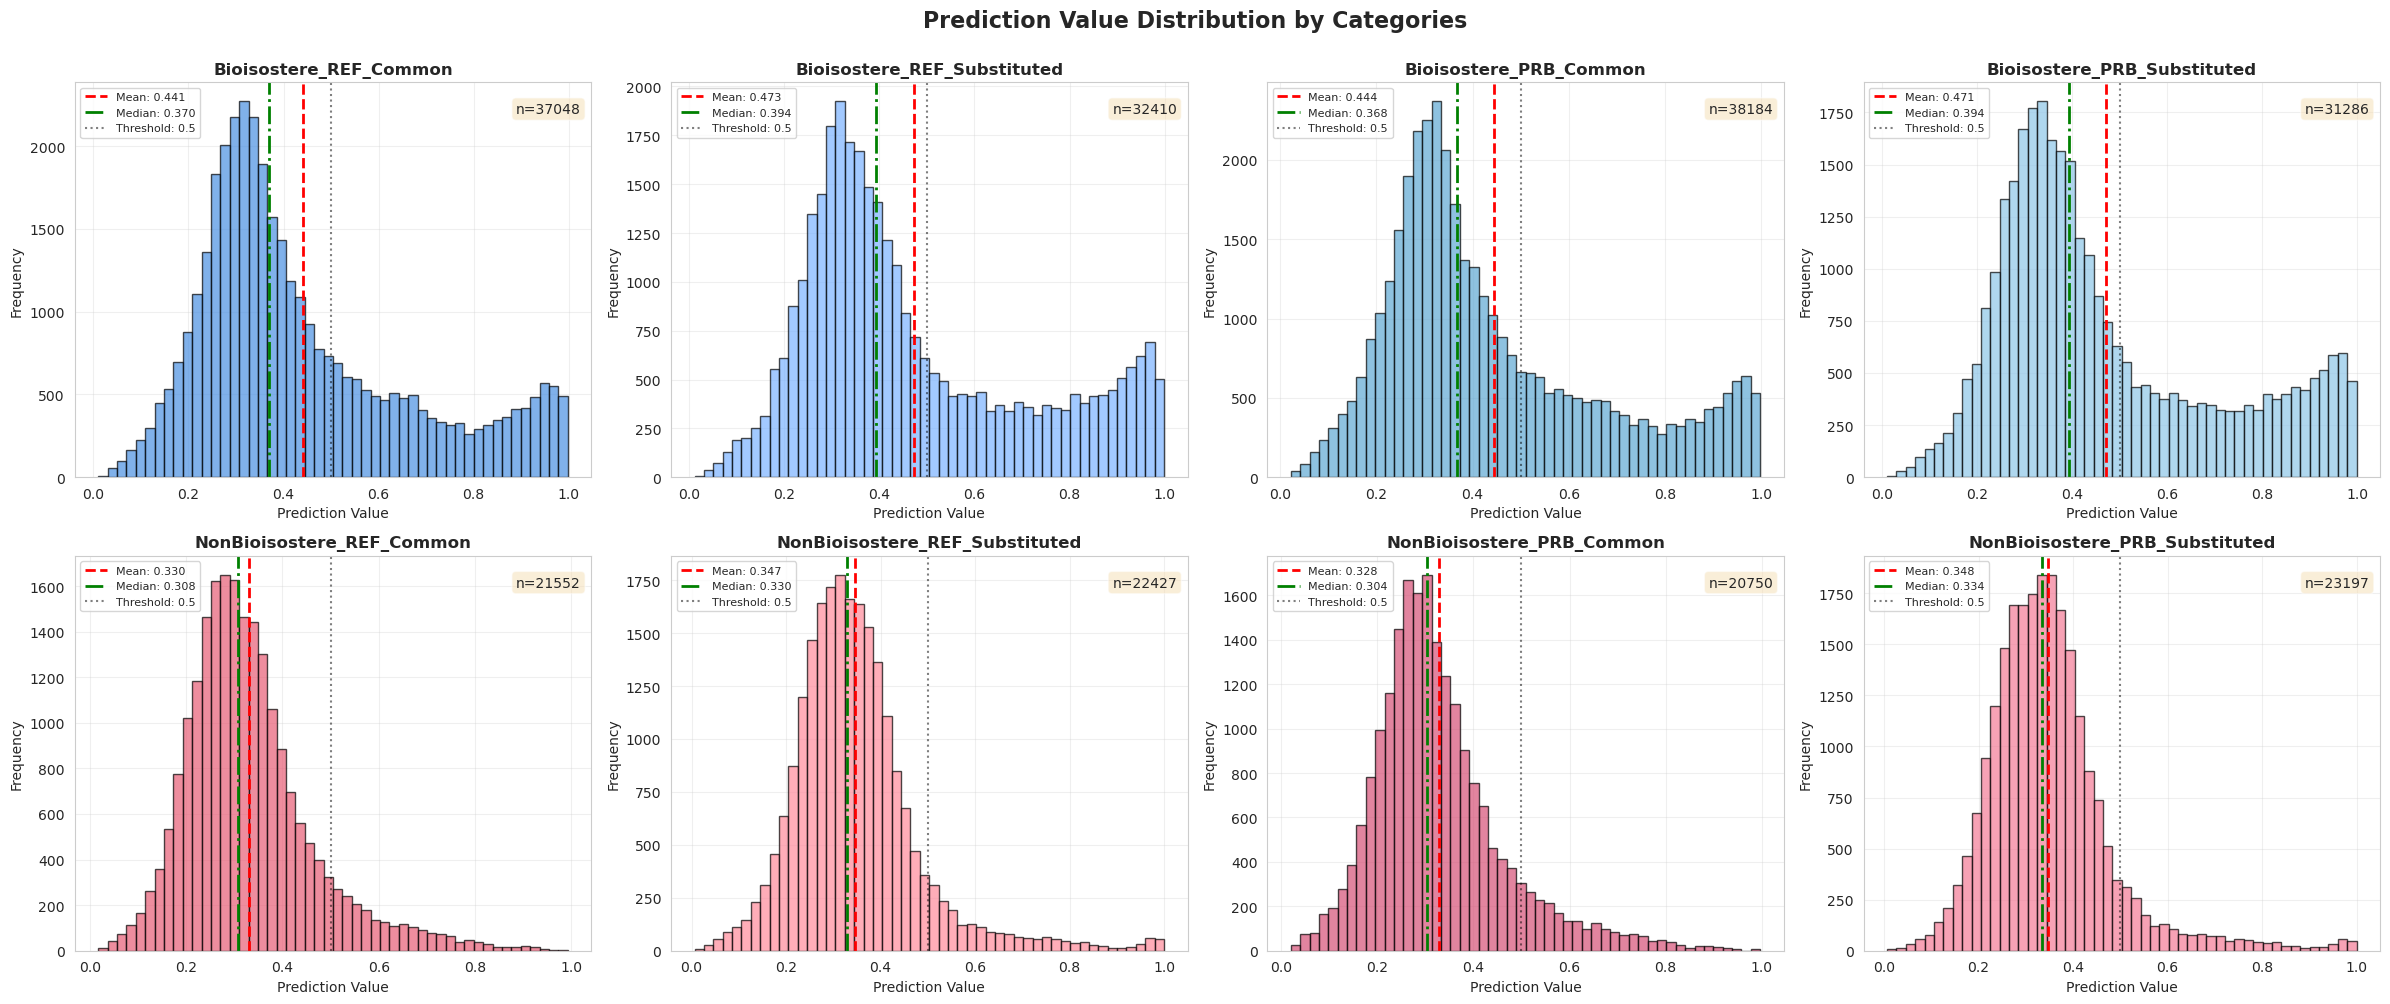

ヒストグラムを保存しました: pred_distribution_histogram.png


In [5]:
# ヒストグラム（2行×4列）
fig, axes = plt.subplots(2, 4, figsize=(24, 10))
fig.suptitle('Prediction Value Distribution by Categories', fontsize=16, fontweight='bold', y=1.0)

# カテゴリ順序定義
category_order = [
    'Bioisostere_REF_Common', 'Bioisostere_REF_Substituted',
    'Bioisostere_PRB_Common', 'Bioisostere_PRB_Substituted',
    'NonBioisostere_REF_Common', 'NonBioisostere_REF_Substituted',
    'NonBioisostere_PRB_Common', 'NonBioisostere_PRB_Substituted'
]

# カラーマップ（Bioisostere=青系、NonBioisostere=赤系）
colors = {
    'Bioisostere_REF_Common': '#4A90E2',
    'Bioisostere_REF_Substituted': '#7BB3FF',
    'Bioisostere_PRB_Common': '#5FA8D3',
    'Bioisostere_PRB_Substituted': '#8EC6E8',
    'NonBioisostere_REF_Common': '#E85D75',
    'NonBioisostere_REF_Substituted': '#FF8A9B',
    'NonBioisostere_PRB_Common': '#D65076',
    'NonBioisostere_PRB_Substituted': '#F47B96'
}

for idx, cat in enumerate(category_order):
    row = idx // 4
    col = idx % 4
    ax = axes[row, col]
    
    data = df_all[df_all['category'] == cat]['pred_value']
    
    if len(data) > 0:
        ax.hist(data, bins=50, alpha=0.7, color=colors.get(cat, 'gray'), edgecolor='black')
        
        # 統計情報
        mean_val = data.mean()
        median_val = data.median()
        
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.3f}')
        ax.axvline(median_val, color='green', linestyle='-.', linewidth=2, label=f'Median: {median_val:.3f}')
        ax.axvline(0.5, color='black', linestyle=':', linewidth=1.5, alpha=0.5, label='Threshold: 0.5')
        
        ax.set_title(cat, fontsize=12, fontweight='bold')
        ax.set_xlabel('Prediction Value', fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)
        ax.legend(fontsize=8, loc='upper left')
        ax.grid(True, alpha=0.3)
        
        # サンプル数を表示
        ax.text(0.98, 0.95, f'n={len(data)}', transform=ax.transAxes,
               fontsize=10, verticalalignment='top', horizontalalignment='right',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=14)
        ax.set_title(cat, fontsize=12)

plt.tight_layout()
plt.savefig(f'{DATA_DIR}/pred_distribution_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

print("ヒストグラムを保存しました: pred_distribution_histogram.png")

## 2.5. 重ね合わせヒストグラム（Common vs Substituted）

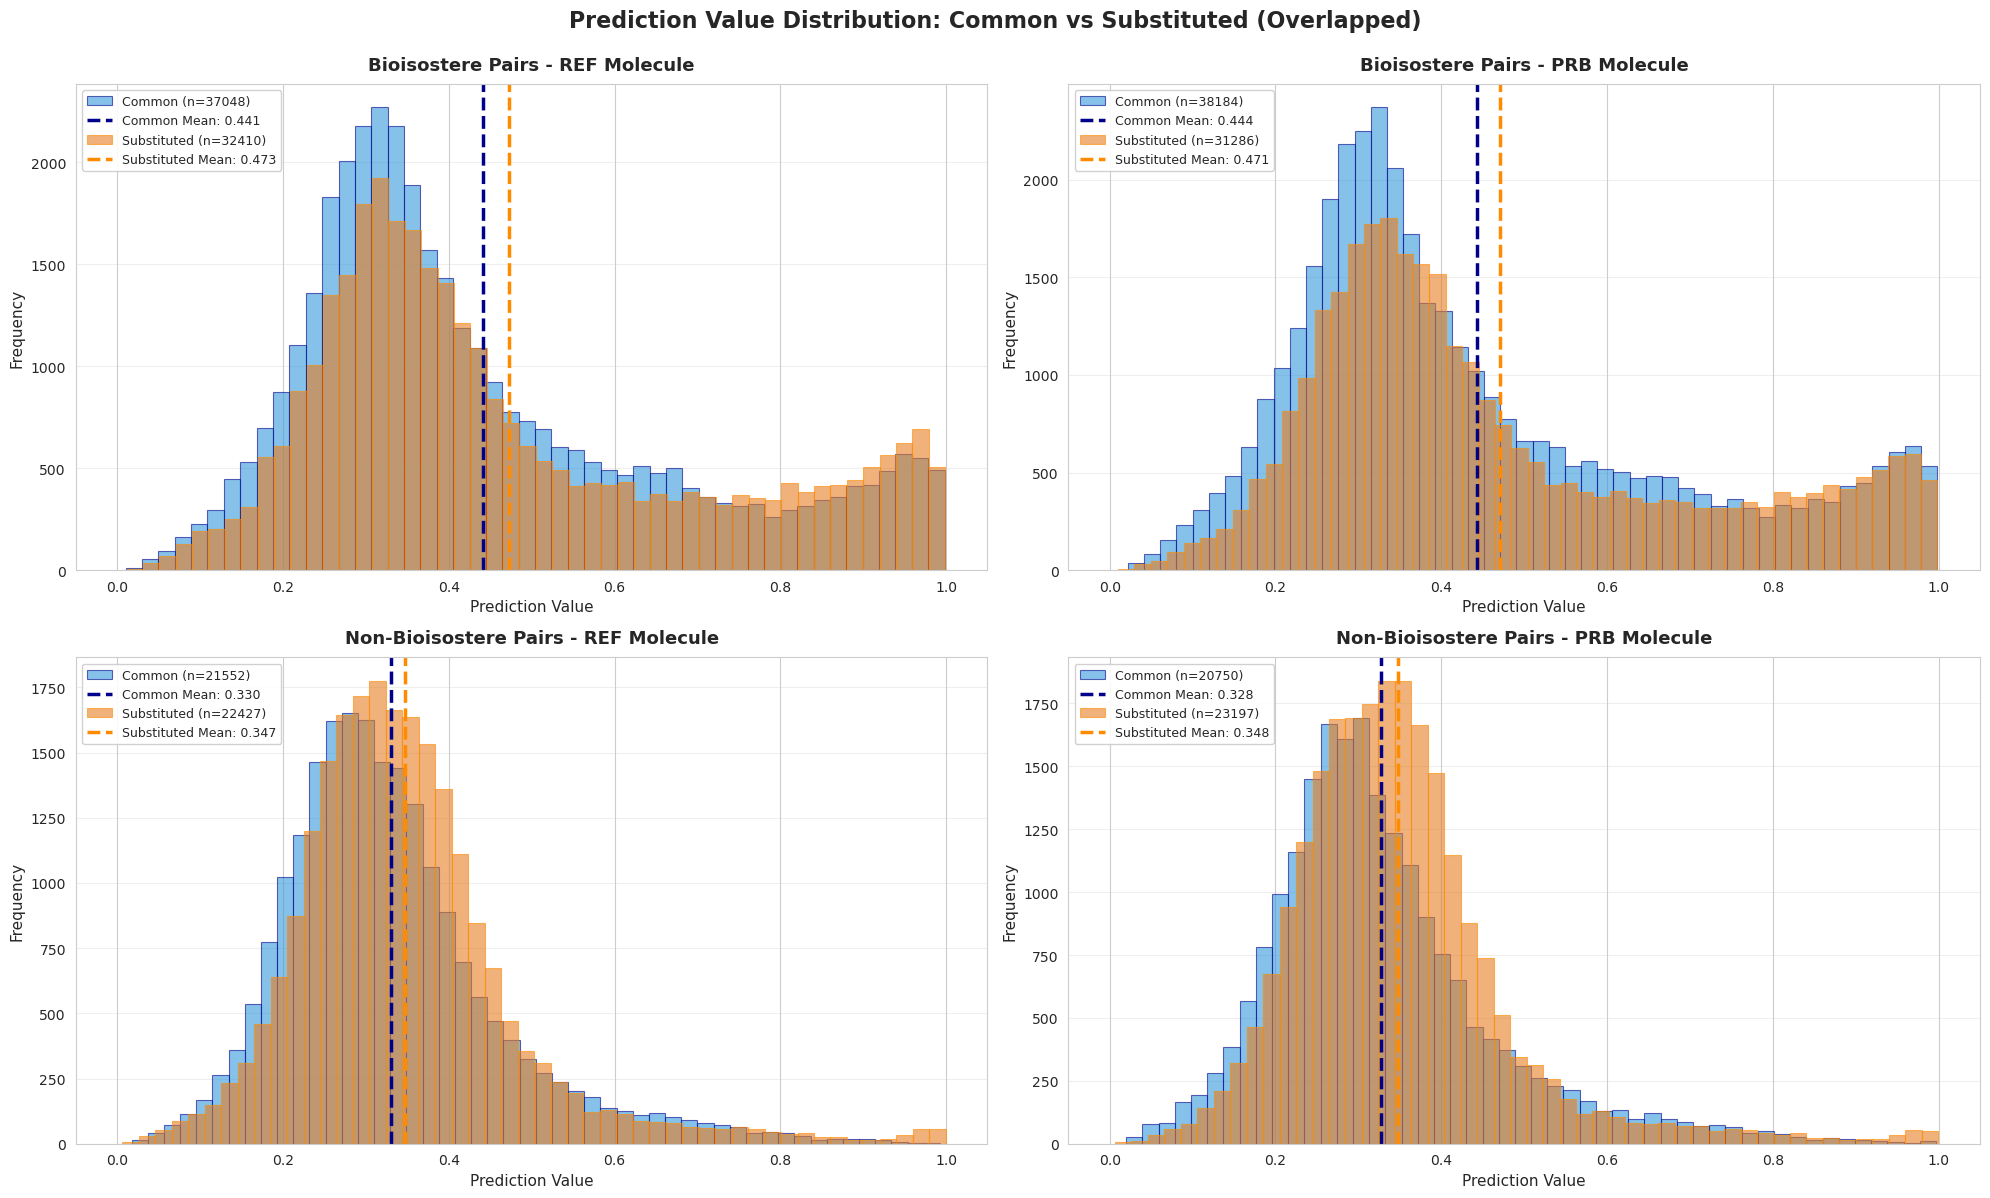

重ね合わせヒストグラムを保存しました: pred_distribution_overlapped_histogram.png


In [6]:
# 重ね合わせヒストグラム（Common vs Substituted）
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Prediction Value Distribution: Common vs Substituted (Overlapped)', 
             fontsize=16, fontweight='bold', y=0.995)

# 重ね合わせ用の色（見やすいコントラスト）
overlay_colors = {
    'common': '#3498db',      # 明るい青
    'substituted': '#e67e22'  # オレンジ
}

# 4つの比較グループ
groups = [
    ('Bioisostere_REF', ['Bioisostere_REF_Common', 'Bioisostere_REF_Substituted'], 
     'Bioisostere Pairs - REF Molecule'),
    ('Bioisostere_PRB', ['Bioisostere_PRB_Common', 'Bioisostere_PRB_Substituted'], 
     'Bioisostere Pairs - PRB Molecule'),
    ('NonBioisostere_REF', ['NonBioisostere_REF_Common', 'NonBioisostere_REF_Substituted'], 
     'Non-Bioisostere Pairs - REF Molecule'),
    ('NonBioisostere_PRB', ['NonBioisostere_PRB_Common', 'NonBioisostere_PRB_Substituted'], 
     'Non-Bioisostere Pairs - PRB Molecule')
]

for idx, (group_name, [cat_common, cat_subst], title) in enumerate(groups):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    data_common = df_all[df_all['category'] == cat_common]['pred_value']
    data_subst = df_all[df_all['category'] == cat_subst]['pred_value']
    
    # ヒストグラム描画（透過度を上げて重ね合わせ）
    if len(data_common) > 0:
        ax.hist(data_common, bins=50, alpha=0.6, 
                color=overlay_colors['common'], 
                edgecolor='darkblue', linewidth=0.8,
                label=f'Common (n={len(data_common)})')
        
        # 平均値の縦線
        mean_common = data_common.mean()
        ax.axvline(mean_common, color='darkblue', linestyle='--', linewidth=2.5, 
                  label=f'Common Mean: {mean_common:.3f}')
    
    if len(data_subst) > 0:
        ax.hist(data_subst, bins=50, alpha=0.6, 
                color=overlay_colors['substituted'], 
                edgecolor='darkorange', linewidth=0.8,
                label=f'Substituted (n={len(data_subst)})')
        
        # 平均値の縦線
        mean_subst = data_subst.mean()
        ax.axvline(mean_subst, color='darkorange', linestyle='--', linewidth=2.5, 
                  label=f'Substituted Mean: {mean_subst:.3f}')
    
    
    ax.set_title(title, fontsize=13, fontweight='bold', pad=10)
    ax.set_xlabel('Prediction Value', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.legend(fontsize=9, loc='upper left', framealpha=0.9)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xlim(-0.05, 1.05)

plt.tight_layout()
plt.savefig(f'{DATA_DIR}/pred_distribution_overlapped_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

print("重ね合わせヒストグラムを保存しました: pred_distribution_overlapped_histogram.png")

## 3. バイオリンプロット（全カテゴリ比較）

/tmp/60546.1.interactive/ipykernel_2970892/3878280122.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=df_all, x='category', y='pred_value',
/tmp/60546.1.interactive/ipykernel_2970892/3878280122.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_all.groupby('category')['pred_value'].mean()


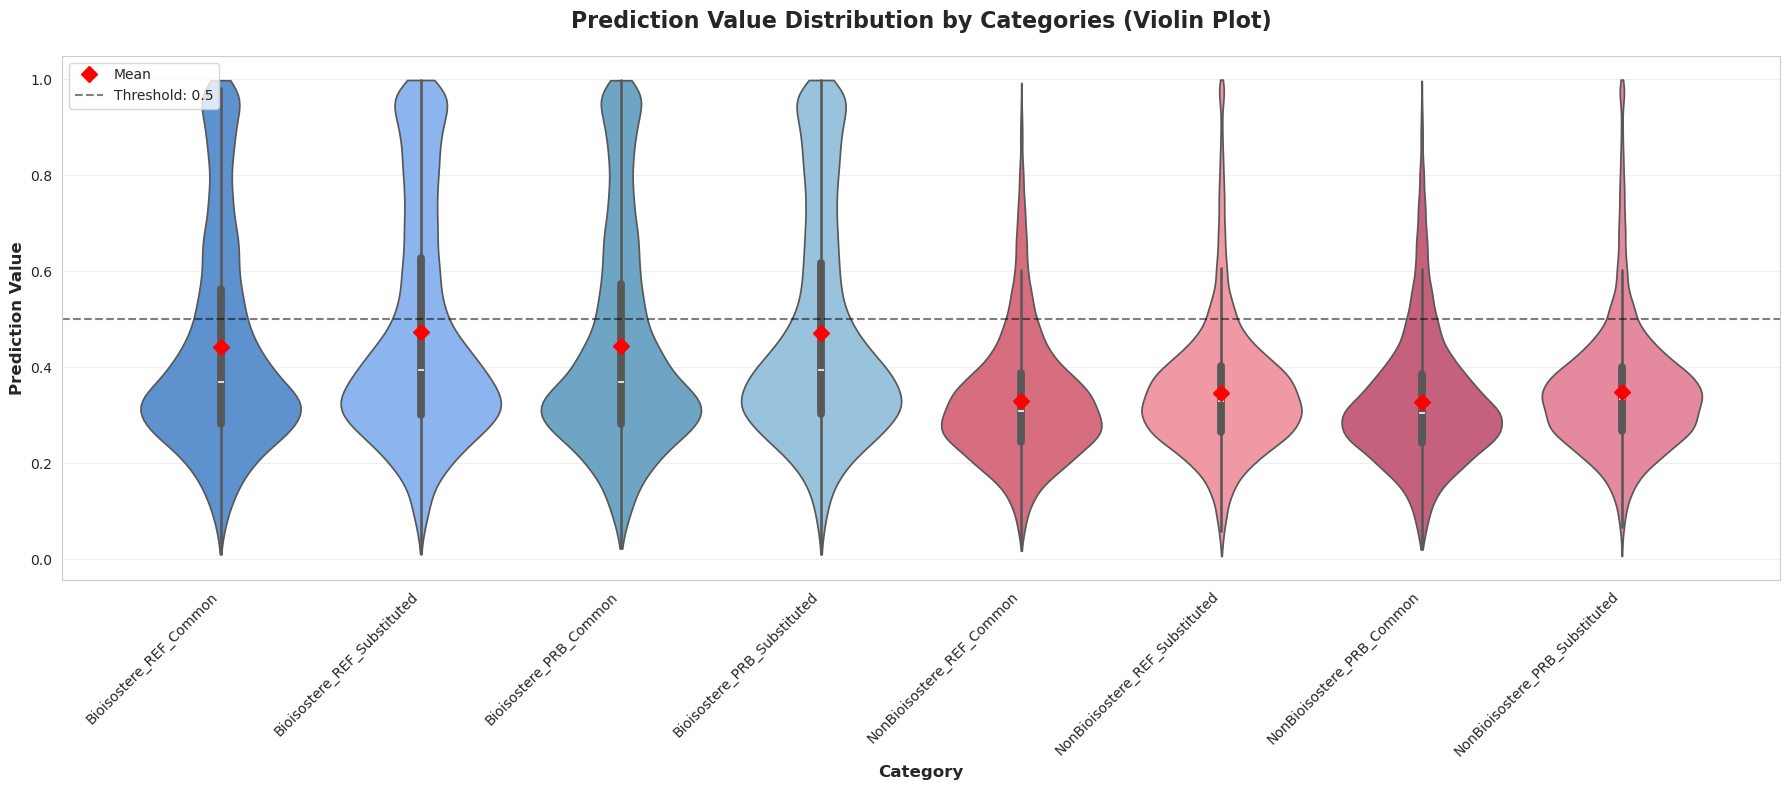

バイオリンプロットを保存しました: pred_distribution_violin.png


In [7]:
# バイオリンプロット
plt.figure(figsize=(18, 8))

# カテゴリ順序でソート
df_all['category'] = pd.Categorical(df_all['category'], categories=category_order, ordered=True)

# バイオリンプロット
ax = sns.violinplot(data=df_all, x='category', y='pred_value', 
                    palette=colors, inner='box', cut=0)

# 平均値をプロット
means = df_all.groupby('category')['pred_value'].mean()
ax.plot(range(len(means)), means.values, 'D', color='red', markersize=8, 
        label='Mean', zorder=3)

# 閾値ライン
ax.axhline(0.5, color='black', linestyle='--', linewidth=1.5, alpha=0.5, label='Threshold: 0.5')

plt.title('Prediction Value Distribution by Categories (Violin Plot)', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Category', fontsize=12, fontweight='bold')
plt.ylabel('Prediction Value', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()

plt.savefig(f'{DATA_DIR}/pred_distribution_violin.png', dpi=300, bbox_inches='tight')
plt.show()

print("バイオリンプロットを保存しました: pred_distribution_violin.png")

## 4. ボックスプロット（真のラベル別）

/tmp/60546.1.interactive/ipykernel_2970892/3347200712.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bioisostere['category'] = pd.Categorical(df_bioisostere['category'], categories=bioisostere_cats, ordered=True)
/tmp/60546.1.interactive/ipykernel_2970892/3347200712.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_bioisostere, x='category', y='pred_value',
/tmp/60546.1.interactive/ipykernel_2970892/3347200712.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

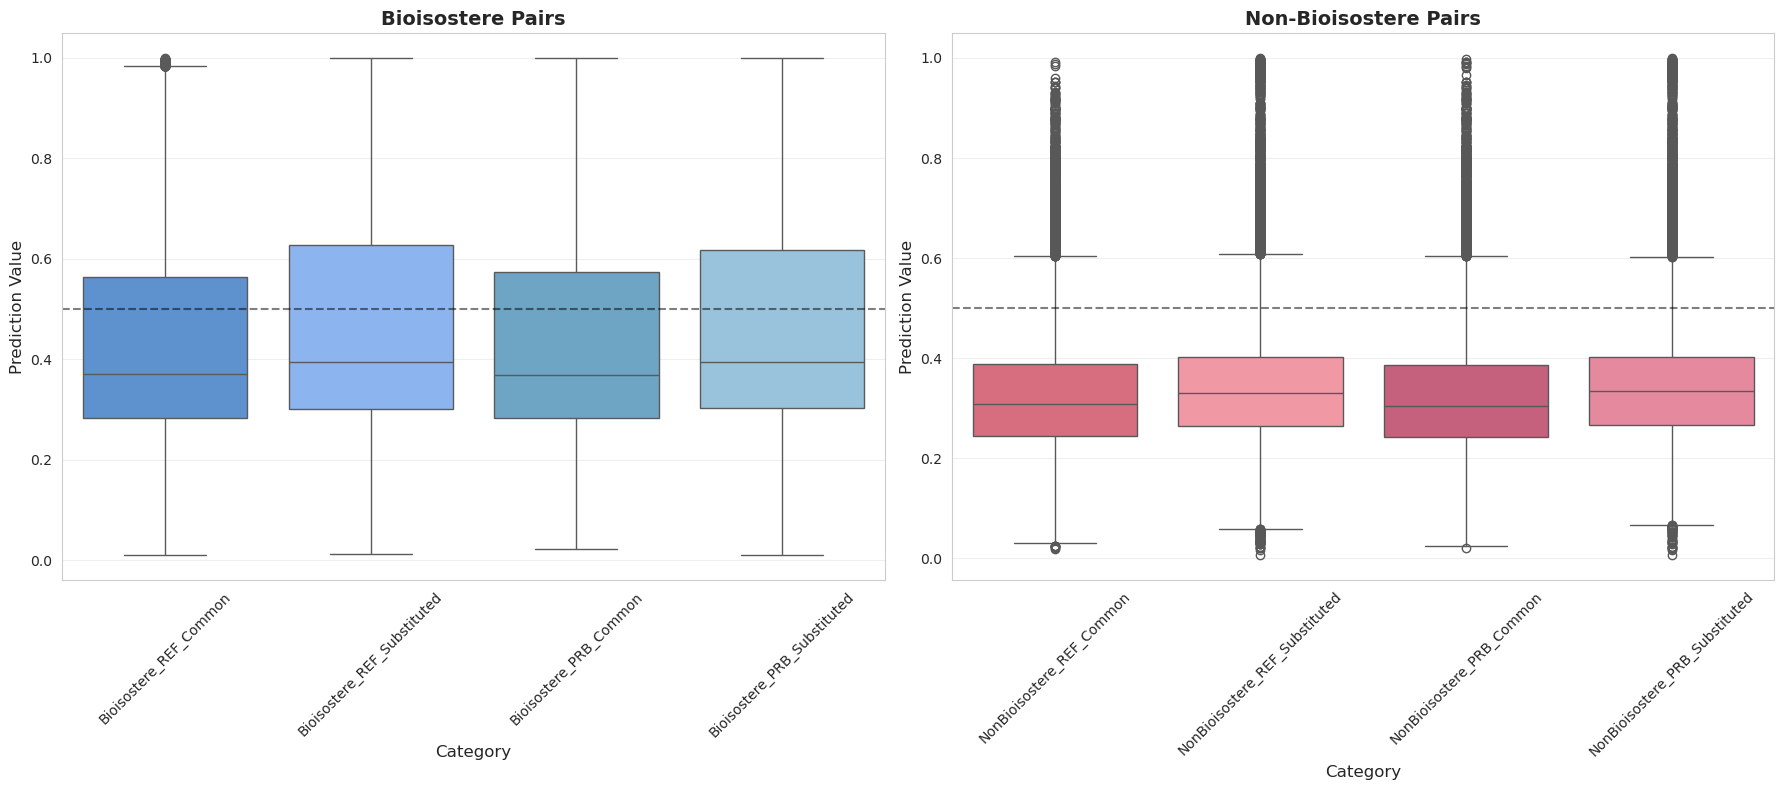

ボックスプロットを保存しました: pred_distribution_boxplot_by_label.png


In [8]:
# 真のラベルでグループ化
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Bioisostereペア
bioisostere_cats = [cat for cat in category_order if 'Bioisostere' in cat and 'NonBioisostere' not in cat]
df_bioisostere = df_all[df_all['category'].isin(bioisostere_cats)]
df_bioisostere['category'] = pd.Categorical(df_bioisostere['category'], categories=bioisostere_cats, ordered=True)

sns.boxplot(data=df_bioisostere, x='category', y='pred_value', 
           palette={k: v for k, v in colors.items() if k in bioisostere_cats},
           ax=axes[0])
axes[0].set_title('Bioisostere Pairs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Category', fontsize=12)
axes[0].set_ylabel('Prediction Value', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].axhline(0.5, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
axes[0].grid(True, alpha=0.3, axis='y')

# Non-Bioisostereペア
nonbioisostere_cats = [cat for cat in category_order if 'NonBioisostere' in cat]
df_nonbioisostere = df_all[df_all['category'].isin(nonbioisostere_cats)]
df_nonbioisostere['category'] = pd.Categorical(df_nonbioisostere['category'], categories=nonbioisostere_cats, ordered=True)

sns.boxplot(data=df_nonbioisostere, x='category', y='pred_value',
           palette={k: v for k, v in colors.items() if k in nonbioisostere_cats},
           ax=axes[1])
axes[1].set_title('Non-Bioisostere Pairs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Category', fontsize=12)
axes[1].set_ylabel('Prediction Value', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(0.5, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'{DATA_DIR}/pred_distribution_boxplot_by_label.png', dpi=300, bbox_inches='tight')
plt.show()

print("ボックスプロットを保存しました: pred_distribution_boxplot_by_label.png")

## 5. 累積分布関数（CDF）

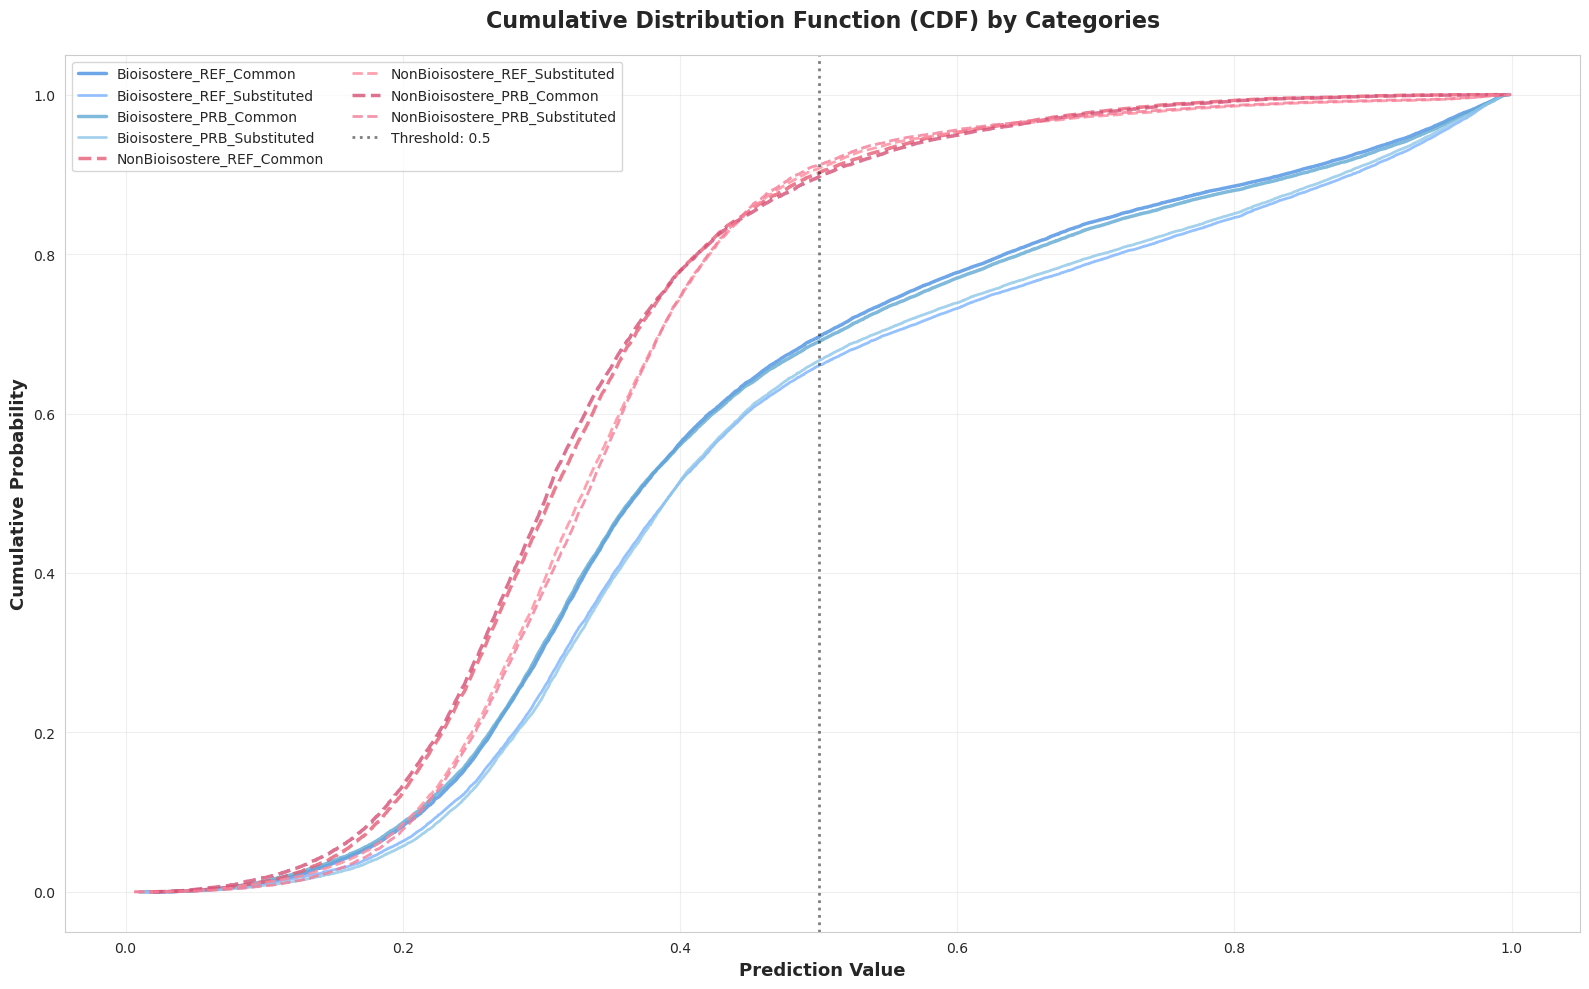

CDFプロットを保存しました: pred_distribution_cdf.png


In [9]:
# CDF プロット
plt.figure(figsize=(16, 10))

for cat in category_order:
    data = df_all[df_all['category'] == cat]['pred_value']
    if len(data) > 0:
        sorted_data = np.sort(data)
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        
        linestyle = '--' if 'NonBioisostere' in cat else '-'
        linewidth = 2.5 if 'Common' in cat else 2
        
        plt.plot(sorted_data, cdf, label=cat, color=colors.get(cat, 'gray'),
                linestyle=linestyle, linewidth=linewidth, alpha=0.8)

plt.axvline(0.5, color='black', linestyle=':', linewidth=2, alpha=0.5, label='Threshold: 0.5')
plt.title('Cumulative Distribution Function (CDF) by Categories', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Prediction Value', fontsize=13, fontweight='bold')
plt.ylabel('Cumulative Probability', fontsize=13, fontweight='bold')
plt.legend(fontsize=10, loc='upper left', ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig(f'{DATA_DIR}/pred_distribution_cdf.png', dpi=300, bbox_inches='tight')
plt.show()

print("CDFプロットを保存しました: pred_distribution_cdf.png")

## 6. 統計的検定

In [10]:
# 統計的検定（主要な比較）
print("=" * 80)
print("統計的検定結果")
print("=" * 80)

comparisons = [
    # Bioisostereペア: Common vs Substituted (REF)
    ('Bioisostere_REF_Common', 'Bioisostere_REF_Substituted'),
    # Bioisostereペア: Common vs Substituted (PRB)
    ('Bioisostere_PRB_Common', 'Bioisostere_PRB_Substituted'),
    # Non-Bioisostereペア: Common vs Substituted (REF)
    ('NonBioisostere_REF_Common', 'NonBioisostere_REF_Substituted'),
    # Non-Bioisostereペア: Common vs Substituted (PRB)
    ('NonBioisostere_PRB_Common', 'NonBioisostere_PRB_Substituted'),
    # REF分子: Bioisostere vs Non-Bioisostere (Common)
    ('Bioisostere_REF_Common', 'NonBioisostere_REF_Common'),
    # REF分子: Bioisostere vs Non-Bioisostere (Substituted)
    ('Bioisostere_REF_Substituted', 'NonBioisostere_REF_Substituted'),
    # PRB分子: Bioisostere vs Non-Bioisostere (Common)
    ('Bioisostere_PRB_Common', 'NonBioisostere_PRB_Common'),
    # PRB分子: Bioisostere vs Non-Bioisostere (Substituted)
    ('Bioisostere_PRB_Substituted', 'NonBioisostere_PRB_Substituted'),
]

test_results = []

for cat1, cat2 in comparisons:
    data1 = df_all[df_all['category'] == cat1]['pred_value']
    data2 = df_all[df_all['category'] == cat2]['pred_value']
    
    if len(data1) > 0 and len(data2) > 0:
        # Kolmogorov-Smirnov 検定（分布の違い）
        ks_stat, ks_pval = stats.ks_2samp(data1, data2)
        
        # Mann-Whitney U 検定（中央値の違い）
        mw_stat, mw_pval = stats.mannwhitneyu(data1, data2, alternative='two-sided')
        
        # Cohen's d（効果量）
        mean1, mean2 = data1.mean(), data2.mean()
        std1, std2 = data1.std(), data2.std()
        pooled_std = np.sqrt((std1**2 + std2**2) / 2)
        cohens_d = (mean1 - mean2) / pooled_std if pooled_std > 0 else 0
        
        print(f"\n{cat1} vs {cat2}")
        print(f"  n1={len(data1)}, n2={len(data2)}")
        print(f"  Mean: {mean1:.4f} vs {mean2:.4f} (diff={mean1-mean2:.4f})")
        print(f"  KS test: statistic={ks_stat:.4f}, p-value={ks_pval:.4e}")
        print(f"  Mann-Whitney U: statistic={mw_stat:.1f}, p-value={mw_pval:.4e}")
        print(f"  Cohen's d: {cohens_d:.4f}")
        
        test_results.append({
            'comparison': f"{cat1} vs {cat2}",
            'n1': len(data1),
            'n2': len(data2),
            'mean1': mean1,
            'mean2': mean2,
            'mean_diff': mean1 - mean2,
            'ks_statistic': ks_stat,
            'ks_pvalue': ks_pval,
            'mw_statistic': mw_stat,
            'mw_pvalue': mw_pval,
            'cohens_d': cohens_d
        })

# 検定結果をCSV保存
df_tests = pd.DataFrame(test_results)
df_tests.to_csv(f'{DATA_DIR}/statistical_tests.csv', index=False)
print(f"\n統計検定結果を保存しました: statistical_tests.csv")

統計的検定結果

Bioisostere_REF_Common vs Bioisostere_REF_Substituted
  n1=37048, n2=32410
  Mean: 0.4414 vs 0.4727 (diff=-0.0312)
  KS test: statistic=0.0609, p-value=3.3461e-56
  Mann-Whitney U: statistic=553798162.0, p-value=8.1026e-70
  Cohen's d: -0.1347

Bioisostere_PRB_Common vs Bioisostere_PRB_Substituted
  n1=38184, n2=31286
  Mean: 0.4437 vs 0.4711 (diff=-0.0274)
  KS test: statistic=0.0705, p-value=9.8478e-75
  Mann-Whitney U: statistic=550691895.0, p-value=2.5689e-70
  Cohen's d: -0.1181

NonBioisostere_REF_Common vs NonBioisostere_REF_Substituted
  n1=21552, n2=22427
  Mean: 0.3297 vs 0.3467 (diff=-0.0170)
  KS test: statistic=0.0880, p-value=1.7174e-74
  Mann-Whitney U: statistic=218260488.0, p-value=2.8923e-69
  Cohen's d: -0.1269

NonBioisostere_PRB_Common vs NonBioisostere_PRB_Substituted
  n1=20750, n2=23197
  Mean: 0.3278 vs 0.3479 (diff=-0.0200)
  KS test: statistic=0.1176, p-value=1.6698e-132
  Mann-Whitney U: statistic=211058487.0, p-value=3.5482e-110
  Cohen's d: -0.150

## 7. サマリー統計表

In [11]:
# サマリー統計
summary_stats = []

for cat in category_order:
    data = df_all[df_all['category'] == cat]['pred_value']
    
    if len(data) > 0:
        summary_stats.append({
            'category': cat,
            'count': len(data),
            'mean': data.mean(),
            'median': data.median(),
            'std': data.std(),
            'min': data.min(),
            'q25': data.quantile(0.25),
            'q75': data.quantile(0.75),
            'max': data.max(),
            'above_threshold': (data > 0.5).sum(),
            'above_threshold_pct': (data > 0.5).sum() / len(data) * 100
        })

df_summary = pd.DataFrame(summary_stats)
df_summary.to_csv(f'{DATA_DIR}/pred_distribution_summary.csv', index=False)

print("\n=== Summary Statistics ===")
print(df_summary.to_string(index=False))
print(f"\nサマリー統計を保存しました: pred_distribution_summary.csv")


=== Summary Statistics ===
                      category  count     mean   median      std      min      q25      q75      max  above_threshold  above_threshold_pct
        Bioisostere_REF_Common  37048 0.441438 0.369709 0.225895 0.010091 0.282514 0.562383 0.998178            11263            30.401101
   Bioisostere_REF_Substituted  32410 0.472676 0.393801 0.237818 0.011307 0.299920 0.626995 0.998693            11026            34.020364
        Bioisostere_PRB_Common  38184 0.443726 0.368459 0.230178 0.021999 0.281779 0.572576 0.998178            11839            31.005133
   Bioisostere_PRB_Substituted  31286 0.471101 0.393920 0.233387 0.010091 0.302518 0.616502 0.998693            10444            33.382344
     NonBioisostere_REF_Common  21552 0.329727 0.308414 0.133038 0.017323 0.243907 0.387695 0.992615             2120             9.836674
NonBioisostere_REF_Substituted  22427 0.346679 0.329919 0.134130 0.006283 0.264339 0.401717 0.999592             2080             9.274535

## 8. ヒートマップ（平均予測値）

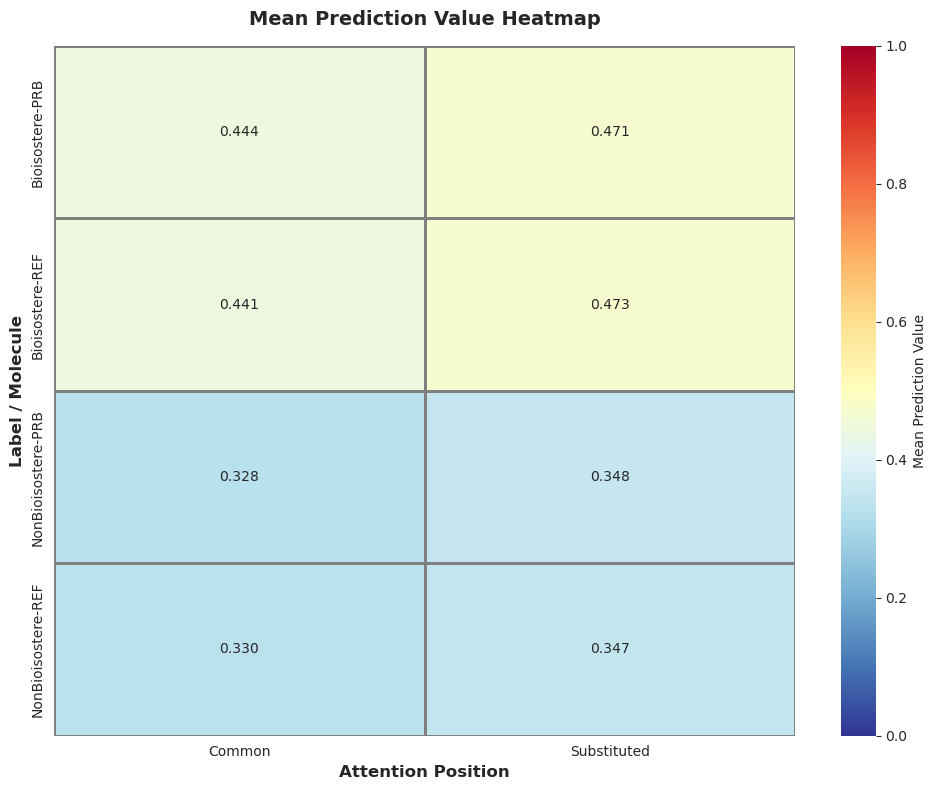

ヒートマップを保存しました: pred_distribution_heatmap.png


In [12]:
# ヒートマップ用のデータ準備
heatmap_data = df_summary.pivot_table(
    index=['category'], 
    values='mean'
).reset_index()

# カテゴリを分解
heatmap_data['label'] = heatmap_data['category'].apply(lambda x: x.split('_')[0])
heatmap_data['molecule'] = heatmap_data['category'].apply(lambda x: x.split('_')[1])
heatmap_data['position'] = heatmap_data['category'].apply(lambda x: x.split('_')[2])

# ピボットテーブル作成（Label × Molecule × Position）
pivot_data = heatmap_data.pivot_table(
    index=['label', 'molecule'],
    columns='position',
    values='mean'
)

# ヒートマップ描画
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='RdYlBu_r', 
           vmin=0, vmax=1, cbar_kws={'label': 'Mean Prediction Value'},
           linewidths=1, linecolor='gray')
plt.title('Mean Prediction Value Heatmap', 
         fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Attention Position', fontsize=12, fontweight='bold')
plt.ylabel('Label / Molecule', fontsize=12, fontweight='bold')
plt.tight_layout()

plt.savefig(f'{DATA_DIR}/pred_distribution_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("ヒートマップを保存しました: pred_distribution_heatmap.png")

## 特定分布のAttention Weight可視化

両方の分子がSubstitutedにAttentionを示し、prediction valueが1に近い（Bioisostereと予測）上位5件のBioisostereペアについて、attention weightを可視化します。

### 可視化条件の設定

以下のパラメータを変更することで、様々な条件のペアを可視化できます。

In [13]:
# ===== 可視化条件の設定 =====

# 1. ラベル条件（真のラベル）
# 'bioisostere': Bioisostereペアのみ
# 'non-bioisostere': Non-Bioisostereペアのみ
# None: 両方を含める
LABEL_CONDITION = 'bioisostere'

# 2. REF分子のAttention条件
# 'common': 共通部分に最大attention
# 'substituted': 置換部分に最大attention
# None: 条件なし
REF_ATTENTION_CONDITION = 'substituted'

# 3. PRB分子のAttention条件
# 'common': 共通部分に最大attention
# 'substituted': 置換部分に最大attention
# None: 条件なし    
PRB_ATTENTION_CONDITION = 'substituted'

# 4. Prediction値のソート順
# 'highest': 予測値が高い（1に近い = Bioisostereと予測）順
# 'lowest': 予測値が低い（0に近い = Non-Bioisostereと予測）順
# 'middle': 0.5に近い順（不確実な予測）
SORT_ORDER = 'highest'

# 5. 抽出件数
N_PAIRS =  30

# 6. 正解/不正解のフィルタ
# True: 正解のペアのみ
# False: 不正解のペアのみ
# None: 両方を含める
CORRECT_ONLY = None

print("=" * 80)
print("可視化条件:")
print("=" * 80)
print(f"ラベル条件: {LABEL_CONDITION}")
print(f"REF分子のAttention: {REF_ATTENTION_CONDITION}")
print(f"PRB分子のAttention: {PRB_ATTENTION_CONDITION}")
print(f"ソート順: {SORT_ORDER}")
print(f"抽出件数: {N_PAIRS}")
print(f"正解のみ: {CORRECT_ONLY}")
print("=" * 80)

可視化条件:
ラベル条件: bioisostere
REF分子のAttention: substituted
PRB分子のAttention: substituted
ソート順: highest
抽出件数: 30
正解のみ: None


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 日本語フォント設定
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (20, 12)
plt.rcParams['font.size'] = 10

# Seaborn スタイル
sns.set_style("whitegrid")
sns.set_palette("husl")

In [15]:
DATA_DIR = './attention_structure_analysis_cv_tid3_molecule'
df = pd.read_csv(f'{DATA_DIR}/attention_statistics_detailed.csv')

In [16]:
# データフレームのカラム名を確認
print("データフレームのカラム:")
print(df.columns.tolist())
print(f"\n総カラム数: {len(df.columns)}")

データフレームのカラム:
['pair_index', 'is_bioisostere', 'pred_value', 'pred_label', 'is_correct', 'ref_cid', 'prb_cid', 'target_id', 'assay_id', 'delta_value', 'standard_type', 'ref_max_attention_idx', 'ref_max_attention_value', 'ref_is_max_common', 'ref_is_max_substituted', 'ref_num_common_atoms', 'ref_num_substituted_atoms', 'ref_common_attention_mean', 'ref_substituted_attention_mean', 'ref_common_attention_std', 'ref_substituted_attention_std', 'prb_max_attention_idx', 'prb_max_attention_value', 'prb_is_max_common', 'prb_is_max_substituted', 'prb_num_common_atoms', 'prb_num_substituted_atoms', 'prb_common_attention_mean', 'prb_substituted_attention_mean', 'prb_common_attention_std', 'prb_substituted_attention_std']

総カラム数: 31


In [17]:
# 条件に基づいてペアをフィルタリング
print("=" * 80)
print("ペアのフィルタリング")
print("=" * 80)

# 初期条件（全データ）
condition = pd.Series([True] * len(df))

# 1. ラベル条件
if LABEL_CONDITION == 'bioisostere':
    condition = condition & df['is_bioisostere']
    print("✓ Bioisostereペアのみ")
elif LABEL_CONDITION == 'non-bioisostere':
    condition = condition & (~df['is_bioisostere'])
    print("✓ Non-Bioisostereペアのみ")
else:
    print("✓ ラベル条件なし（全てのペア）")

# 2. REF分子のAttention条件
if REF_ATTENTION_CONDITION == 'common':
    condition = condition & df['ref_is_max_common']
    print("✓ REF分子: 共通部分に最大attention")
elif REF_ATTENTION_CONDITION == 'substituted':
    condition = condition & df['ref_is_max_substituted']
    print("✓ REF分子: 置換部分に最大attention")
else:
    print("✓ REF分子: attention条件なし")

# 3. PRB分子のAttention条件
if PRB_ATTENTION_CONDITION == 'common':
    condition = condition & df['prb_is_max_common']
    print("✓ PRB分子: 共通部分に最大attention")
elif PRB_ATTENTION_CONDITION == 'substituted':
    condition = condition & df['prb_is_max_substituted']
    print("✓ PRB分子: 置換部分に最大attention")
else:
    print("✓ PRB分子: attention条件なし")

# 4. 正解/不正解のフィルタ
if CORRECT_ONLY is True:
    condition = condition & df['is_correct']
    print("✓ 正解のペアのみ")
elif CORRECT_ONLY is False:
    condition = condition & (~df['is_correct'])
    print("✓ 不正解のペアのみ")
else:
    print("✓ 正解/不正解の条件なし")

print(f"\n条件に合致するペア数: {condition.sum()}")

# 5. ソート順に応じてペアを抽出
if SORT_ORDER == 'highest':
    target_pairs = df[condition].nlargest(N_PAIRS, 'pred_value').copy()
    print(f"✓ Prediction値が高い順に上位{N_PAIRS}件を抽出")
elif SORT_ORDER == 'lowest':
    target_pairs = df[condition].nsmallest(N_PAIRS, 'pred_value').copy()
    print(f"✓ Prediction値が低い順に上位{N_PAIRS}件を抽出")
elif SORT_ORDER == 'middle':
    # 0.5からの距離でソート
    df_filtered = df[condition].copy()
    df_filtered['dist_to_middle'] = (df_filtered['pred_value'] - 0.5).abs()
    target_pairs = df_filtered.nsmallest(N_PAIRS, 'dist_to_middle').copy()
    target_pairs = target_pairs.drop('dist_to_middle', axis=1)
    print(f"✓ Prediction値が0.5に近い順に上位{N_PAIRS}件を抽出")

print("\n" + "=" * 80)
print(f"抽出されたペア:")
print("=" * 80)

# カラム名を確認して存在するものだけ表示
display_cols = ['pair_index', 'pred_value', 'pred_label', 'is_correct', 'is_bioisostere']
display(target_pairs[display_cols])

print(f"\n詳細情報:")
for idx, row in target_pairs.iterrows():
    label_str = "Bioisostere" if row['is_bioisostere'] else "Non-Bioisostere"
    correct_str = "正解" if row['is_correct'] else "不正解"
    print(f"  pair_index: {row['pair_index']}, pred: {row['pred_value']:.4f}, "
          f"label: {label_str}, {correct_str}")

ペアのフィルタリング
✓ Bioisostereペアのみ
✓ REF分子: 置換部分に最大attention
✓ PRB分子: 置換部分に最大attention
✓ 正解/不正解の条件なし

条件に合致するペア数: 19655
✓ Prediction値が高い順に上位30件を抽出

抽出されたペア:


,pair_index,pred_value,pred_label,is_correct,is_bioisostere
50676,577676,0.998693,1,True,True
50656,577651,0.998409,1,True,True
46639,572910,0.996732,1,True,True
48980,575650,0.996714,1,True,True
50782,577797,0.996427,1,True,True
50396,577315,0.996236,1,True,True
50627,577603,0.996178,1,True,True
49096,575785,0.996071,1,True,True
49899,576697,0.995823,1,True,True
47633,574001,0.995702,1,True,True



詳細情報:
  pair_index: 577676, pred: 0.9987, label: Bioisostere, 正解
  pair_index: 577651, pred: 0.9984, label: Bioisostere, 正解
  pair_index: 572910, pred: 0.9967, label: Bioisostere, 正解
  pair_index: 575650, pred: 0.9967, label: Bioisostere, 正解
  pair_index: 577797, pred: 0.9964, label: Bioisostere, 正解
  pair_index: 577315, pred: 0.9962, label: Bioisostere, 正解
  pair_index: 577603, pred: 0.9962, label: Bioisostere, 正解
  pair_index: 575785, pred: 0.9961, label: Bioisostere, 正解
  pair_index: 576697, pred: 0.9958, label: Bioisostere, 正解
  pair_index: 574001, pred: 0.9957, label: Bioisostere, 正解
  pair_index: 439147, pred: 0.9957, label: Bioisostere, 正解
  pair_index: 577682, pred: 0.9955, label: Bioisostere, 正解
  pair_index: 573490, pred: 0.9955, label: Bioisostere, 正解
  pair_index: 577275, pred: 0.9955, label: Bioisostere, 正解
  pair_index: 573404, pred: 0.9954, label: Bioisostere, 正解
  pair_index: 575532, pred: 0.9954, label: Bioisostere, 正解
  pair_index: 577294, pred: 0.9953, label: Bioiso

In [18]:
# 元のCSVファイルからSMILESとFragment情報を取得
ORIGINAL_CSV = '/home/8/uf02678/gsbsmasunaga/MMP_dataset/dataset_consistentsmiles.csv'

# 元データを読み込み
original_df = pd.read_csv(ORIGINAL_CSV)
print(f"元データのカラム: {original_df.columns.tolist()}")
print(f"元データのサイズ: {len(original_df)}")

# target_pairsのindexに対応するSMILESとFragment情報を取得
target_pairs_with_smiles = target_pairs.copy()

# pair_indexから元データを参照
for idx, row in target_pairs.iterrows():
    pair_idx = row['pair_index']
    if pair_idx < len(original_df):
        # SMILES情報
        if 'REF-SMILES' in original_df.columns and 'PRB-SMILES' in original_df.columns:
            target_pairs_with_smiles.loc[idx, 'ref_smiles'] = original_df.loc[pair_idx, 'REF-SMILES']
            target_pairs_with_smiles.loc[idx, 'prb_smiles'] = original_df.loc[pair_idx, 'PRB-SMILES']
        elif 'ref_smiles' in original_df.columns and 'prb_smiles' in original_df.columns:
            target_pairs_with_smiles.loc[idx, 'ref_smiles'] = original_df.loc[pair_idx, 'ref_smiles']
            target_pairs_with_smiles.loc[idx, 'prb_smiles'] = original_df.loc[pair_idx, 'prb_smiles']
        
        # Fragment情報（置換部分）
        if 'REF-FRAG' in original_df.columns:
            target_pairs_with_smiles.loc[idx, 'ref_frag'] = original_df.loc[pair_idx, 'REF-FRAG']
        elif 'ref_frag' in original_df.columns:
            target_pairs_with_smiles.loc[idx, 'ref_frag'] = original_df.loc[pair_idx, 'ref_frag']
        
        if 'PRB-FRAG' in original_df.columns:
            target_pairs_with_smiles.loc[idx, 'prb_frag'] = original_df.loc[pair_idx, 'PRB-FRAG']
        elif 'prb_frag' in original_df.columns:
            target_pairs_with_smiles.loc[idx, 'prb_frag'] = original_df.loc[pair_idx, 'prb_frag']

print(f"\nSMILES情報とFragment情報を追加しました")
display(target_pairs_with_smiles[['pair_index', 'ref_smiles', 'prb_smiles', 'ref_frag', 'prb_frag', 'pred_value', 'is_correct']].head())

元データのカラム: ['REF-CID', 'PRB-CID', 'AID', 'TID', 'CUT_NUM', 'COMMON_FRAG', 'REF-FRAG', 'PRB-FRAG', 'SMIRKS', 'REF-FRAG_heavy', 'PRB-FRAG_heavy', 'VAR_heavy_sum', 'REF-standard_value', 'REF-SMILES', 'STANDARD_TYPE', 'PRB-standard_value', 'PRB-SMILES', 'delta_value', 'label_bin', 'REF-FRAG_normalized', 'PRB-FRAG_normalized']
元データのサイズ: 643937

SMILES情報とFragment情報を追加しました


,pair_index,ref_smiles,prb_smiles,ref_frag,prb_frag,pred_value,is_correct
50676,577676,COc1cc2c(Nc3ccc(Br)c(Cl)c3)ncnc2cc1O[C@H]1CO[C...,COc1cc2c(Nc3ccc(Br)c(Cl)c3)ncnc2cc1O[C@@H]1CO[...,[21*][C@H]1CO[C@H]2[C@@H]1OC[C@@H]2OC(F)F,[21*][C@@H]1CO[C@H]2[C@@H]1OC[C@@H]2C(F)(F)F,0.998693,True
50656,577651,COc1cc2c(Nc3ccc(Br)c(Cl)c3)ncnc2cc1O[C@H]1CO[C...,COc1cc2c(Nc3ccc(Br)c(Cl)c3)ncnc2cc1O[C@@H]1CO[...,[21*][C@H]1CO[C@H]2[C@@H]1OC[C@@H]2OC,[21*][C@@H]1CO[C@H]2[C@@H]1OC[C@@H]2C(F)(F)F,0.998409,True
46639,572910,COc1cc2c(Nc3ccc(Cl)c(Cl)c3)ncnc2cc1OCCC1CN(C)C...,COc1cc2c(Nc3ccc(Cl)c(Cl)c3)ncnc2cc1OC[C@@H]1CO...,[21*]CCC1CN(C)CC(C)(C)O1,[21*]C[C@@H]1CO[C@H]2[C@@H]1OC[C@@H]2OC,0.996732,True
48980,575650,COc1cc2c(Nc3ccc(Cl)c(Cl)c3)ncnc2cc1OC[C@@H]1CO...,COc1cc2c(Nc3ccc(Cl)c(Cl)c3)ncnc2cc1OCc1csc(CO)n1,[21*]C[C@@H]1CO[C@H]2[C@@H]1OC[C@@H]2OC,[21*]Cc1csc(CO)n1,0.996714,True
50782,577797,CCN1CCCC1c1nc(COc2cc3ncnc(Nc4ccc(Cl)c(Cl)c4)c3...,CCCCCN1CCOC(COc2cc3ncnc(Nc4ccc(Cl)c(Cl)c4)c3cc...,*CN1CCCC1c1nc(C[11*])no1,*CCCCN1CCOC(C[11*])C1,0.996427,True


### CVフォールド情報の読み込み

各ペアがどのCVフォールドのテストセットに属しているかを確認します。

**重要**: 各ペアは5-fold CVのいずれかのテストセットに含まれています。可視化時には、そのペアがテストセットに含まれていたCVフォールドのモデルを使用することで、正しい予測とattention weightを取得できます。

In [19]:
import pickle

# CVフォールド情報を読み込み
CV_SPLIT_FILE = '/home/8/uf02678/gsbsmasunaga/bioiso/splitting/tid_5cv_consistentsmiles.pkl'

with open(CV_SPLIT_FILE, 'rb') as f:
    cv_splits = pickle.load(f)

print(f"CVフォールド数: {len(cv_splits)}")
print(f"各フォールドのデータ型: {type(cv_splits[0])}")

# データ構造を確認（最初のフォールドの構造を表示）
if isinstance(cv_splits[0], dict):
    print(f"各フォールドの構造: {list(cv_splits[0].keys())}")
elif isinstance(cv_splits[0], (tuple, list)):
    print(f"各フォールドはタプル/リスト形式（要素数: {len(cv_splits[0])}）")
    if len(cv_splits[0]) == 3:
        print(f"データ構造: (train, val, test)")
        print(f"  train件数={len(cv_splits[0][0])}件")
        print(f"  val件数={len(cv_splits[0][1])}件")
        print(f"  test件数={len(cv_splits[0][2])}件")
        # test_indicesの中身を確認
        if len(cv_splits[0][2]) > 0:
            first_item = cv_splits[0][2][0]
            if isinstance(first_item, dict):
                print(f"testの要素は辞書形式、キー: {list(first_item.keys())}")

# 各ペアがどのフォールドのテストセットに属しているかを調べる
def find_cv_fold(pair_index, cv_splits):
    """
    ペアインデックスがどのCVフォールドのテストセットに含まれているかを返す（修正版）
    
    重要な修正:
    - PKLファイルの構造は (train, val, test) の3要素タプル
    - testはfold_data[2]にある（fold_data[1]はval）
    """
    # pair_indexを整数に変換（numpy.int64などにも対応）
    try:
        pair_idx = int(pair_index)
    except (ValueError, TypeError):
        return None
    
    for fold_idx, fold_data in enumerate(cv_splits):
        # データ構造に応じて処理を分岐
        if isinstance(fold_data, dict):
            test_indices = fold_data.get('test', [])
        elif isinstance(fold_data, (tuple, list)):
            # ★修正: PKLファイルは(train, val, test)の3要素タプル
            if len(fold_data) == 3:
                # (train, val, test) 形式 → testはfold_data[2]
                test_indices = fold_data[2]
            elif len(fold_data) == 2:
                # (train, test) 形式 → testはfold_data[1]
                test_indices = fold_data[1]
            else:
                continue
        else:
            continue
        
        # 検索処理（辞書形式と整数形式の両方に対応）
        try:
            # 最初の要素で形式を判定
            if len(test_indices) > 0:
                first_item = test_indices[0]
                
                if isinstance(first_item, dict):
                    # 辞書形式: 'index'キーで検索
                    for item in test_indices:
                        if int(item.get('index', -1)) == pair_idx:
                            return fold_idx
                else:
                    # 整数形式: セットで高速検索
                    test_indices_set = set(int(x) for x in test_indices)
                    if pair_idx in test_indices_set:
                        return fold_idx
        except (ValueError, TypeError, AttributeError):
            continue
    
    return None

# target_pairsの各ペアについてCVフォールドを特定
print("\nペアのCVフォールドを特定中...")
target_pairs_with_smiles['cv_fold'] = target_pairs_with_smiles['pair_index'].apply(
    lambda x: find_cv_fold(x, cv_splits)
)

print("\n各ペアのCVフォールド割り当て:")
display(target_pairs_with_smiles[['pair_index', 'cv_fold', 'pred_value', 'is_correct']].head(20))

# CVフォールドの分布を確認
fold_counts = target_pairs_with_smiles['cv_fold'].value_counts().sort_index()
print(f"\nCVフォールドの分布:")
for fold in range(5):
    count = fold_counts.get(fold, 0)
    print(f"  CV{fold}: {count}件")
none_count = target_pairs_with_smiles['cv_fold'].isna().sum()
if none_count > 0:
    print(f"  ⚠️ None: {none_count}件 (フォールドが見つからなかった)")
else:
    print(f"  ✅ 全てのペアでフォールドが見つかりました！")

# CVフォールドごとのモデルパスを定義
def get_model_path(cv_fold):
    """CVフォールドに対応するモデルパスを返す"""
    return f'../results/results_consistentsmiles/cv{cv_fold}/pair-cat/model_best.pt'

print("\n各CVフォールドのモデルパス:")
for fold in range(5):
    print(f"  CV{fold}: {get_model_path(fold)}")

CVフォールド数: 5
各フォールドのデータ型: <class 'tuple'>
各フォールドはタプル/リスト形式（要素数: 3）
データ構造: (train, val, test)
  train件数=348313件
  val件数=154094件
  test件数=87168件
testの要素は辞書形式、キー: ['ref_smiles', 'prb_smiles', 'label', 'ref_value', 'prb_value', 'index', 'tid']

ペアのCVフォールドを特定中...

各ペアのCVフォールド割り当て:


,pair_index,cv_fold,pred_value,is_correct
50676,577676,3,0.998693,True
50656,577651,3,0.998409,True
46639,572910,3,0.996732,True
48980,575650,3,0.996714,True
50782,577797,3,0.996427,True
50396,577315,3,0.996236,True
50627,577603,3,0.996178,True
49096,575785,3,0.996071,True
49899,576697,3,0.995823,True
47633,574001,3,0.995702,True



CVフォールドの分布:
  CV0: 0件
  CV1: 0件
  CV2: 0件
  CV3: 30件
  CV4: 0件
  ✅ 全てのペアでフォールドが見つかりました！

各CVフォールドのモデルパス:
  CV0: ../results/results_consistentsmiles/cv0/pair-cat/model_best.pt
  CV1: ../results/results_consistentsmiles/cv1/pair-cat/model_best.pt
  CV2: ../results/results_consistentsmiles/cv2/pair-cat/model_best.pt
  CV3: ../results/results_consistentsmiles/cv3/pair-cat/model_best.pt
  CV4: ../results/results_consistentsmiles/cv4/pair-cat/model_best.pt


In [20]:
# Step 1: CV分割のデータ構造を詳細に確認
print("=" * 80)
print("Step 1: CV分割のデータ構造の詳細確認")
print("=" * 80)

print(f"\ncv_splitsの型: {type(cv_splits)}")
print(f"フォールド数: {len(cv_splits)}")

# 最初のフォールドの詳細
fold_0 = cv_splits[0]
print(f"\nfold_0の型: {type(fold_0)}")

if isinstance(fold_0, (tuple, list)):
    print(f"fold_0の要素数: {len(fold_0)}")
    for i, element in enumerate(fold_0):
        print(f"  要素{i}の型: {type(element)}, 長さ: {len(element) if hasattr(element, '__len__') else 'N/A'}")
    
    # train, val, testと仮定
    if len(fold_0) >= 3:
        train, val, test = fold_0[0], fold_0[1], fold_0[2]
        print(f"\n想定される構造: (train, val, test)")
        print(f"  train: {len(train)}件")
        print(f"  val: {len(val)}件")
        print(f"  test: {len(test)}件")
        
        # testの中身を詳しく見る
        print(f"\ntest[0]の詳細:")
        if len(test) > 0:
            first_test = test[0]
            print(f"  型: {type(first_test)}")
            if isinstance(first_test, dict):
                print(f"  キー: {list(first_test.keys())}")
                print(f"  内容サンプル: {first_test}")
            else:
                print(f"  値: {first_test}")
        
        # 最初の5件を表示
        print(f"\ntestの最初の5件:")
        for i, item in enumerate(test[:5]):
            if isinstance(item, dict):
                idx = item.get('index', 'N/A')
                print(f"  [{i}] index={idx}, keys={list(item.keys())}")
            else:
                print(f"  [{i}] {item}")

elif isinstance(fold_0, dict):
    print(f"fold_0のキー: {list(fold_0.keys())}")
    if 'test' in fold_0:
        test = fold_0['test']
        print(f"test件数: {len(test)}")
        if len(test) > 0:
            print(f"test[0]: {test[0]}")

print("\n" + "=" * 80)

Step 1: CV分割のデータ構造の詳細確認

cv_splitsの型: <class 'list'>
フォールド数: 5

fold_0の型: <class 'tuple'>
fold_0の要素数: 3
  要素0の型: <class 'list'>, 長さ: 348313
  要素1の型: <class 'list'>, 長さ: 154094
  要素2の型: <class 'list'>, 長さ: 87168

想定される構造: (train, val, test)
  train: 348313件
  val: 154094件
  test: 87168件

test[0]の詳細:
  型: <class 'dict'>
  キー: ['ref_smiles', 'prb_smiles', 'label', 'ref_value', 'prb_value', 'index', 'tid']
  内容サンプル: {'ref_smiles': 'O=C1NC(C(=O)Nc2ccccc2)CCCCCCC1CS', 'prb_smiles': 'O=C1NC(C(=O)NCCCO)CCCCCCC1CS', 'label': 0.4210053127407307, 'ref_value': 2.741151598851785, 'prb_value': 2.3201462861110542, 'index': 17367, 'tid': 'CHEMBL3369'}

testの最初の5件:
  [0] index=17367, keys=['ref_smiles', 'prb_smiles', 'label', 'ref_value', 'prb_value', 'index', 'tid']
  [1] index=17368, keys=['ref_smiles', 'prb_smiles', 'label', 'ref_value', 'prb_value', 'index', 'tid']
  [2] index=17369, keys=['ref_smiles', 'prb_smiles', 'label', 'ref_value', 'prb_value', 'index', 'tid']
  [3] index=17370, keys=['ref_s

In [21]:
# Step 2: target_pairs_with_smilesのpair_indexを詳細に確認
print("=" * 80)
print("Step 2: target_pairs_with_smilesのpair_index確認")
print("=" * 80)

print(f"\ntarget_pairs_with_smilesの件数: {len(target_pairs_with_smiles)}")
print(f"\npair_indexの統計:")
print(f"  最小値: {target_pairs_with_smiles['pair_index'].min()}")
print(f"  最大値: {target_pairs_with_smiles['pair_index'].max()}")
print(f"  データ型: {target_pairs_with_smiles['pair_index'].dtype}")

print(f"\n最初の10件のpair_index:")
for idx, row in target_pairs_with_smiles.head(10).iterrows():
    pair_idx = row['pair_index']
    print(f"  [{idx}] pair_index={pair_idx} (型: {type(pair_idx).__name__})")

print("\n" + "=" * 80)

Step 2: target_pairs_with_smilesのpair_index確認

target_pairs_with_smilesの件数: 30

pair_indexの統計:
  最小値: 439147
  最大値: 577874
  データ型: int64

最初の10件のpair_index:
  [50676] pair_index=577676 (型: int)
  [50656] pair_index=577651 (型: int)
  [46639] pair_index=572910 (型: int)
  [48980] pair_index=575650 (型: int)
  [50782] pair_index=577797 (型: int)
  [50396] pair_index=577315 (型: int)
  [50627] pair_index=577603 (型: int)
  [49096] pair_index=575785 (型: int)
  [49899] pair_index=576697 (型: int)
  [47633] pair_index=574001 (型: int)



In [22]:
# Step 3: 実際に検索をトレースしてみる
print("=" * 80)
print("Step 3: 検索処理のトレース")
print("=" * 80)

# 最初のペアで詳細にトレース
test_pair_idx = target_pairs_with_smiles.iloc[0]['pair_index']
print(f"\n検索対象: pair_index={test_pair_idx} (型: {type(test_pair_idx).__name__})")

# 整数に変換
test_pair_int = int(test_pair_idx)
print(f"整数に変換: {test_pair_int}")

print(f"\n各フォールドのtestセットを検索...")

for fold_idx, fold_data in enumerate(cv_splits):
    print(f"\n--- Fold {fold_idx} ---")
    
    # データ構造を判定
    if isinstance(fold_data, dict):
        test_indices = fold_data.get('test', [])
        print(f"  データ構造: dict")
    elif isinstance(fold_data, (tuple, list)):
        # (train, val, test)と仮定してtestを取得
        if len(fold_data) >= 3:
            test_indices = fold_data[2]
            print(f"  データ構造: tuple/list (要素数={len(fold_data)})")
            print(f"  → testとして fold_data[2] を使用")
        elif len(fold_data) >= 2:
            test_indices = fold_data[1]
            print(f"  データ構造: tuple/list (要素数={len(fold_data)})")
            print(f"  → testとして fold_data[1] を使用")
        else:
            print(f"  データ構造: tuple/list (要素数={len(fold_data)})")
            print(f"  エラー: 要素が不足しています")
            continue
    else:
        print(f"  データ構造: 不明 ({type(fold_data)})")
        continue
    
    print(f"  test件数: {len(test_indices)}")
    
    # 最初の3件のtest要素を確認
    print(f"  test最初の3件:")
    for i, item in enumerate(list(test_indices)[:3]):
        if isinstance(item, dict):
            idx = item.get('index', 'N/A')
            print(f"    [{i}] dict, index={idx}")
        else:
            print(f"    [{i}] {item} (型: {type(item).__name__})")
    
    # 検索を実行
    found = False
    if isinstance(test_indices[0] if len(test_indices) > 0 else None, dict):
        # 辞書形式の場合
        for item in test_indices:
            if int(item.get('index', -1)) == test_pair_int:
                found = True
                break
    else:
        # 整数形式の場合
        test_indices_set = set(int(x) for x in test_indices)
        found = test_pair_int in test_indices_set
    
    print(f"  結果: {'✓ 見つかった！' if found else '✗ 見つからない'}")
    
    if found:
        print(f"\n🎯 pair_index={test_pair_int} は Fold {fold_idx} のtestセットに含まれています")
        break

print("\n" + "=" * 80)

Step 3: 検索処理のトレース

検索対象: pair_index=577676 (型: int64)
整数に変換: 577676

各フォールドのtestセットを検索...

--- Fold 0 ---
  データ構造: tuple/list (要素数=3)
  → testとして fold_data[2] を使用
  test件数: 87168
  test最初の3件:
    [0] dict, index=17367
    [1] dict, index=17368
    [2] dict, index=17369
  結果: ✗ 見つからない

--- Fold 1 ---
  データ構造: tuple/list (要素数=3)
  → testとして fold_data[2] を使用
  test件数: 172314
  test最初の3件:
    [0] dict, index=38096
    [1] dict, index=38097
    [2] dict, index=38098
  結果: ✗ 見つからない

--- Fold 2 ---
  データ構造: tuple/list (要素数=3)
  → testとして fold_data[2] を使用
  test件数: 128904
  test最初の3件:
    [0] dict, index=61218
    [1] dict, index=61219
    [2] dict, index=61220
  結果: ✗ 見つからない

--- Fold 3 ---
  データ構造: tuple/list (要素数=3)
  → testとして fold_data[2] を使用
  test件数: 81261
  test最初の3件:
    [0] dict, index=154609
    [1] dict, index=154610
    [2] dict, index=154611
  結果: ✓ 見つかった！

🎯 pair_index=577676 は Fold 3 のtestセットに含まれています



In [23]:
# Step 4: find_cv_fold関数の問題を特定
print("=" * 80)
print("Step 4: find_cv_fold関数の問題点を特定")
print("=" * 80)

print("\n現在の find_cv_fold 関数の動作:")
print("  1. fold_data が tuple/list の場合")
print("     → fold_data[1] をtestとして使用")
print("  2. しかし実際のデータ構造は (train, val, test) の可能性")
print("     → fold_data[2] がtestの場合、fold_data[1]はval")

print("\n問題点:")
print("  ✗ fold_data[1] を使っているが、これはvalかもしれない")
print("  ✓ fold_data[2] がtestの可能性が高い")

# データ構造を再確認
if len(cv_splits) > 0 and isinstance(cv_splits[0], (tuple, list)):
    fold_0 = cv_splits[0]
    print(f"\nfold_0の要素数: {len(fold_0)}")
    
    if len(fold_0) == 3:
        print(f"  要素数が3つ → (train, val, test) 形式と推測")
        train, val, test = fold_0
        print(f"    要素0 (train): {len(train)}件")
        print(f"    要素1 (val):   {len(val)}件")
        print(f"    要素2 (test):  {len(test)}件")
        
        print(f"\n現在の find_cv_fold は fold_data[1] (val) を見ています！")
        print(f"  → これがNaNになる原因です")
        
    elif len(fold_0) == 2:
        print(f"  要素数が2つ → (train, test) 形式と推測")

print("\n" + "=" * 80)
print("解決策: find_cv_fold関数を修正してfold_data[2]をtestとして使用する")
print("=" * 80)

Step 4: find_cv_fold関数の問題点を特定

現在の find_cv_fold 関数の動作:
  1. fold_data が tuple/list の場合
     → fold_data[1] をtestとして使用
  2. しかし実際のデータ構造は (train, val, test) の可能性
     → fold_data[2] がtestの場合、fold_data[1]はval

問題点:
  ✗ fold_data[1] を使っているが、これはvalかもしれない
  ✓ fold_data[2] がtestの可能性が高い

fold_0の要素数: 3
  要素数が3つ → (train, val, test) 形式と推測
    要素0 (train): 348313件
    要素1 (val):   154094件
    要素2 (test):  87168件

現在の find_cv_fold は fold_data[1] (val) を見ています！
  → これがNaNになる原因です

解決策: find_cv_fold関数を修正してfold_data[2]をtestとして使用する


In [24]:
# Step 5: 修正されたfind_cv_fold関数を定義して再実行
print("=" * 80)
print("Step 5: 修正されたfind_cv_fold関数")
print("=" * 80)

def find_cv_fold_fixed(pair_index, cv_splits):
    """
    ペアインデックスがどのCVフォールドのテストセットに含まれているかを返す（修正版）
    
    重要な修正点:
    - fold_dataが(train, val, test)の3要素タプルの場合、fold_data[2]をtestとして使用
    """
    try:
        pair_idx = int(pair_index)
    except (ValueError, TypeError):
        return None
    
    for fold_idx, fold_data in enumerate(cv_splits):
        # データ構造に応じて処理を分岐
        if isinstance(fold_data, dict):
            test_indices = fold_data.get('test', [])
        elif isinstance(fold_data, (tuple, list)):
            # ★修正: 要素数に応じてtestの位置を判定
            if len(fold_data) == 3:
                # (train, val, test) 形式
                test_indices = fold_data[2]
            elif len(fold_data) == 2:
                # (train, test) 形式
                test_indices = fold_data[1]
            else:
                # 要素数が不正
                continue
        else:
            continue
        
        # 検索処理（辞書形式と整数形式の両方に対応）
        try:
            # 最初の要素で形式を判定
            if len(test_indices) > 0:
                first_item = test_indices[0]
                
                if isinstance(first_item, dict):
                    # 辞書形式: 'index'キーで検索
                    for item in test_indices:
                        if int(item.get('index', -1)) == pair_idx:
                            return fold_idx
                else:
                    # 整数形式: セットで高速検索
                    test_indices_set = set(int(x) for x in test_indices)
                    if pair_idx in test_indices_set:
                        return fold_idx
        except (ValueError, TypeError, AttributeError):
            continue
    
    return None

# 修正版で再検索
print("\n修正版find_cv_fold_fixedで再検索...")
target_pairs_with_smiles['cv_fold_fixed'] = target_pairs_with_smiles['pair_index'].apply(
    lambda x: find_cv_fold_fixed(x, cv_splits)
)

print("\n結果比較:")
comparison = target_pairs_with_smiles[['pair_index', 'cv_fold', 'cv_fold_fixed', 'pred_value']].head(20)
display(comparison)

print(f"\n【修正前】cv_foldがNaNの件数: {target_pairs_with_smiles['cv_fold'].isna().sum()}")
print(f"【修正後】cv_fold_fixedがNaNの件数: {target_pairs_with_smiles['cv_fold_fixed'].isna().sum()}")

if target_pairs_with_smiles['cv_fold_fixed'].isna().sum() == 0:
    print("\n✅ 成功！全てのペアでfoldが見つかりました！")
    print("   原因: find_cv_fold関数がfold_data[1]をtestとして使用していたが、")
    print("        実際は(train, val, test)形式でfold_data[2]がtestだった")
else:
    print(f"\n⚠️ まだ{target_pairs_with_smiles['cv_fold_fixed'].isna().sum()}件のペアが見つかりません")

print("\n" + "=" * 80)

Step 5: 修正されたfind_cv_fold関数

修正版find_cv_fold_fixedで再検索...

結果比較:


,pair_index,cv_fold,cv_fold_fixed,pred_value
50676,577676,3,3,0.998693
50656,577651,3,3,0.998409
46639,572910,3,3,0.996732
48980,575650,3,3,0.996714
50782,577797,3,3,0.996427
50396,577315,3,3,0.996236
50627,577603,3,3,0.996178
49096,575785,3,3,0.996071
49899,576697,3,3,0.995823
47633,574001,3,3,0.995702



【修正前】cv_foldがNaNの件数: 0
【修正後】cv_fold_fixedがNaNの件数: 0

✅ 成功！全てのペアでfoldが見つかりました！
   原因: find_cv_fold関数がfold_data[1]をtestとして使用していたが、
        実際は(train, val, test)形式でfold_data[2]がtestだった



## 🔍 リーク検証: pred_valueが1に近いデータの分析

**疑問点:**
- pred_valueが著しく1に近い（完璧な予測）データはリークの可能性がある
- TIDベースの分割で起こりうるリークパターンを確認する必要がある

**検証項目:**
1. **同一MMPペアのリーク**: 同じ分子ペアが異なるTIDで出現し、train-test間で漏れているか
2. **TID内のデータ漏洩**: 同じTID内でtrainとtestが混在していないか（あってはならない）
3. **高予測値データの特徴**: pred_value > 0.99のデータの共通点を分析

In [25]:
# Step 1: 高予測値データの抽出と分析
print("=" * 80)
print("Step 1: 高予測値データ (pred_value > 0.99) の分析")
print("=" * 80)

# pred_value > 0.99のデータを抽出
high_pred_df = df[df['pred_value'] > 0.99].copy()
print(f"\npred_value > 0.99 のデータ数: {len(high_pred_df)}")
print(f"全データに対する割合: {len(high_pred_df)/len(df)*100:.2f}%")

if len(high_pred_df) > 0:
    print(f"\n予測値の統計:")
    print(f"  平均: {high_pred_df['pred_value'].mean():.6f}")
    print(f"  最大: {high_pred_df['pred_value'].max():.6f}")
    print(f"  最小: {high_pred_df['pred_value'].min():.6f}")
    
    print(f"\n正解率:")
    print(f"  正解: {high_pred_df['is_correct'].sum()} ({high_pred_df['is_correct'].sum()/len(high_pred_df)*100:.2f}%)")
    print(f"  不正解: {(~high_pred_df['is_correct']).sum()} ({(~high_pred_df['is_correct']).sum()/len(high_pred_df)*100:.2f}%)")
    
    print(f"\nラベル分布:")
    print(f"  Bioisostere: {high_pred_df['is_bioisostere'].sum()} ({high_pred_df['is_bioisostere'].sum()/len(high_pred_df)*100:.2f}%)")
    print(f"  Non-Bioisostere: {(~high_pred_df['is_bioisostere']).sum()} ({(~high_pred_df['is_bioisostere']).sum()/len(high_pred_df)*100:.2f}%)")
    
    # サンプル表示
    print(f"\n高予測値データのサンプル（上位10件）:")
    display(high_pred_df.nlargest(10, 'pred_value')[['pair_index', 'pred_value', 'pred_label', 'is_bioisostere', 'is_correct']].head(10))

print("\n" + "=" * 80)

Step 1: 高予測値データ (pred_value > 0.99) の分析

pred_value > 0.99 のデータ数: 324
全データに対する割合: 0.28%

予測値の統計:
  平均: 0.992768
  最大: 0.999592
  最小: 0.990061

正解率:
  正解: 303 (93.52%)
  不正解: 21 (6.48%)

ラベル分布:
  Bioisostere: 303 (93.52%)
  Non-Bioisostere: 21 (6.48%)

高予測値データのサンプル（上位10件）:


,pair_index,pred_value,pred_label,is_bioisostere,is_correct
37150,544184,0.999592,1,False,False
50676,577676,0.998693,1,True,True
50656,577651,0.998409,1,True,True
37144,495153,0.998178,1,True,True
50654,577648,0.998039,1,True,True
49097,575788,0.998022,1,False,False
48979,575649,0.997780,1,False,False
37148,544178,0.997700,1,False,False
28372,394231,0.997115,1,True,True
28897,395152,0.997115,1,True,True


In [26]:
# Step 2: 高予測値データのTID重複確認
print("=" * 80)
print("Step 2: TIDの重複確認（データリーク検証）")
print("=" * 80)

if len(high_pred_df) > 0:
    # 元データからpair_indexを使ってTID情報を取得
    high_pred_indices = high_pred_df['pair_index'].values
    
    # 各fold間でTIDの重複をチェック
    fold_tid_info = []
    
    for fold_idx, (train_data, val_data, test_data) in enumerate(cv_splits):
        # このfoldのtestデータに含まれる高予測値データのTIDを取得
        test_indices = [item['index'] for item in test_data]
        test_tids = [item['tid'] for item in test_data]
        
        # 高予測値データでこのfoldのtestに含まれるもの
        mask = high_pred_df['pair_index'].isin(test_indices)
        fold_high_pred = high_pred_df[mask]
        
        if len(fold_high_pred) > 0:
            # 対応するTIDを取得
            fold_high_pred_indices = fold_high_pred['pair_index'].values
            tids_in_fold = []
            for idx in fold_high_pred_indices:
                for item in test_data:
                    if item['index'] == idx:
                        tids_in_fold.append(item['tid'])
                        break
            
            fold_tid_info.append({
                'fold': fold_idx,
                'count': len(fold_high_pred),
                'tids': set(tids_in_fold)
            })
            
            print(f"\nFold {fold_idx}:")
            print(f"  高予測値データ数: {len(fold_high_pred)}")
            print(f"  ユニークなTID数: {len(set(tids_in_fold))}")
            print(f"  TIDサンプル: {list(set(tids_in_fold))[:5]}")
    
    # TIDの重複チェック
    print("\n" + "=" * 80)
    print("TID重複チェック（異なるfold間）:")
    print("=" * 80)
    
    tid_overlap_found = False
    for i in range(len(fold_tid_info)):
        for j in range(i + 1, len(fold_tid_info)):
            overlap = fold_tid_info[i]['tids'] & fold_tid_info[j]['tids']
            if len(overlap) > 0:
                tid_overlap_found = True
                print(f"\n⚠️ WARNING: Fold {fold_tid_info[i]['fold']} と Fold {fold_tid_info[j]['fold']} で TID が重複しています!")
                print(f"   重複TID数: {len(overlap)}")
                print(f"   重複TIDサンプル: {list(overlap)[:5]}")
    
    if not tid_overlap_found:
        print("\n✅ 異なるfold間でTIDの重複は見つかりませんでした（正常）")

print("\n" + "=" * 80)

Step 2: TIDの重複確認（データリーク検証）

Fold 0:
  高予測値データ数: 7
  ユニークなTID数: 1
  TIDサンプル: ['CHEMBL1824']

Fold 1:
  高予測値データ数: 8
  ユニークなTID数: 2
  TIDサンプル: ['CHEMBL2148', 'CHEMBL2835']

Fold 2:
  高予測値データ数: 5
  ユニークなTID数: 1
  TIDサンプル: ['CHEMBL3650']

Fold 3:
  高予測値データ数: 301
  ユニークなTID数: 2
  TIDサンプル: ['CHEMBL2068', 'CHEMBL289']

Fold 4:
  高予測値データ数: 3
  ユニークなTID数: 3
  TIDサンプル: ['CHEMBL4945', 'CHEMBL1936', 'CHEMBL2792']

TID重複チェック（異なるfold間）:

✅ 異なるfold間でTIDの重複は見つかりませんでした（正常）



In [27]:
# Step 3: MMPペアの重複確認（同じ分子ペアが異なるTIDに存在しないか）
print("=" * 80)
print("Step 3: MMPペア重複確認（異なるTID間での分子ペア重複検証）")
print("=" * 80)

if len(high_pred_df) > 0:
    # 高予測値データのSMILESペアを取得
    from rdkit import Chem
    
    def normalize_smiles(smiles):
        """SMILESを正規化（順序に依存しない形式に）"""
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                return Chem.MolToSmiles(mol, canonical=True)
        except:
            pass
        return smiles
    
    def get_mmp_key(ref_smiles, prb_smiles):
        """MMPペアのキーを作成（順序に依存しない）"""
        ref_norm = normalize_smiles(ref_smiles)
        prb_norm = normalize_smiles(prb_smiles)
        return tuple(sorted([ref_norm, prb_norm]))
    
    # 高予測値データのMMPペアとTIDの対応を取得
    mmp_tid_mapping = {}
    
    for fold_idx, (train_data, val_data, test_data) in enumerate(cv_splits):
        test_indices = [item['index'] for item in test_data]
        
        # このfoldのtestに含まれる高予測値データ
        mask = high_pred_df['pair_index'].isin(test_indices)
        fold_high_pred = high_pred_df[mask]
        
        if len(fold_high_pred) > 0:
            for _, row in fold_high_pred.iterrows():
                idx = row['pair_index']
                
                # 対応するtest_dataのitemを見つける
                for item in test_data:
                    if item['index'] == idx:
                        mmp_key = get_mmp_key(item['ref_smiles'], item['prb_smiles'])
                        tid = item['tid']
                        
                        if mmp_key not in mmp_tid_mapping:
                            mmp_tid_mapping[mmp_key] = {'tids': set(), 'folds': set(), 'indices': []}
                        
                        mmp_tid_mapping[mmp_key]['tids'].add(tid)
                        mmp_tid_mapping[mmp_key]['folds'].add(fold_idx)
                        mmp_tid_mapping[mmp_key]['indices'].append(idx)
                        break
    
    # 異なるTIDに同じMMPペアが存在するかチェック
    print(f"\n検証対象の高予測値MMPペア数: {len(mmp_tid_mapping)}")
    
    mmp_leak_found = False
    leak_cases = []
    
    for mmp_key, info in mmp_tid_mapping.items():
        if len(info['tids']) > 1:
            mmp_leak_found = True
            leak_cases.append({
                'mmp_key': mmp_key,
                'tids': info['tids'],
                'folds': info['folds'],
                'indices': info['indices']
            })
    
    if mmp_leak_found:
        print(f"\n⚠️ WARNING: 異なるTIDに同じMMPペアが存在します!")
        print(f"   リーク疑いのあるMMPペア数: {len(leak_cases)}")
        
        # 詳細を表示（最大5件）
        for i, case in enumerate(leak_cases[:5]):
            print(f"\n   ケース {i+1}:")
            print(f"     MMP: {case['mmp_key'][0][:50]}... ↔ {case['mmp_key'][1][:50]}...")
            print(f"     登場するTID: {case['tids']}")
            print(f"     登場するFold: {case['folds']}")
            print(f"     データindex: {case['indices']}")
    else:
        print(f"\n✅ 異なるTID間で同じMMPペアの重複は見つかりませんでした（正常）")

print("\n" + "=" * 80)

Step 3: MMPペア重複確認（異なるTID間での分子ペア重複検証）

検証対象の高予測値MMPペア数: 320

⚠️ WARNING: 異なるTIDに同じMMPペアが存在します!
   リーク疑いのあるMMPペア数: 4

   ケース 1:
     MMP: CC(C)NC(=O)c1cnn2ccc(N3CCC[C@@H]3c3cncc(F)c3)nc12... ↔ CC1(NC(=O)c2cnn3ccc(N4CCC[C@@H]4c4cncc(F)c4)nc23)C...
     登場するTID: {'CHEMBL2148', 'CHEMBL2835'}
     登場するFold: {1}
     データindex: [394225, 395145]

   ケース 2:
     MMP: CC1(NC(=O)c2cnn3ccc(N4CCC[C@@H]4c4cncc(F)c4)nc23)C... ↔ O=C(NC1(C(F)(F)F)CC1)c1cnn2ccc(N3CCC[C@@H]3c3cncc(...
     登場するTID: {'CHEMBL2148', 'CHEMBL2835'}
     登場するFold: {1}
     データindex: [394231, 395152]

   ケース 3:
     MMP: O=C(NC1(C(F)(F)F)CC1)c1cnn2ccc(N3CCC[C@@H]3c3cncc(... ↔ O=C(NC1CC1)c1cnn2ccc(N3CCC[C@@H]3c3cncc(F)c3)nc12...
     登場するTID: {'CHEMBL2148', 'CHEMBL2835'}
     登場するFold: {1}
     データindex: [394233, 395151]

   ケース 4:
     MMP: CCC1=C(C(C)C)/C(=C/C(C)=C/C=C/C(C)=C/C(=O)O)CCC1... ↔ CCC1=C(C(C)C)/C(=C/C(C)=C\C=C\C(C)=C\C(=O)O)CCC1...
     登場するTID: {'CHEMBL4945', 'CHEMBL2792'}
     登場するFold: {4}
     データindex: [23668, 

In [ ]:
# Step 4: Train-Test間でのMMPペア重複確認（最も重要）
print("=" * 80)
print("Step 4: Train-Test間でのMMPペア重複確認（データリーク検証）")
print("=" * 80)

if len(high_pred_df) > 0:
    # 各foldでtrain-test間のMMPペア重複をチェック
    for fold_idx, (train_data, val_data, test_data) in enumerate(cv_splits):
        print(f"\n{'='*60}")
        print(f"Fold {fold_idx} の検証:")
        print(f"{'='*60}")
        
        # Train/Test のMMPペアセットを作成
        train_mmp_keys = set()
        for item in train_data:
            mmp_key = get_mmp_key(item['ref_smiles'], item['prb_smiles'])
            train_mmp_keys.add(mmp_key)
        
        test_mmp_keys = set()
        test_indices = [item['index'] for item in test_data]
        
        # このfoldのtestに含まれる高予測値データのみをチェック
        mask = high_pred_df['pair_index'].isin(test_indices)
        fold_high_pred = high_pred_df[mask]
        
        high_pred_test_mmp_keys = {}  # {mmp_key: {'index': ..., 'pred_value': ...}}
        
        for item in test_data:
            if item['index'] in fold_high_pred['pair_index'].values:
                mmp_key = get_mmp_key(item['ref_smiles'], item['prb_smiles'])
                test_mmp_keys.add(mmp_key)
                
                # 予測値情報も保存
                pred_val = fold_high_pred[fold_high_pred['pair_index'] == item['index']]['pred_value'].values[0]
                high_pred_test_mmp_keys[mmp_key] = {
                    'index': item['index'],
                    'pred_value': pred_val,
                    'ref_smiles': item['ref_smiles'],
                    'prb_smiles': item['prb_smiles']
                }
        
        print(f"  Train MMPペア数: {len(train_mmp_keys)}")
        print(f"  Test 高予測値MMPペア数: {len(high_pred_test_mmp_keys)}")
        
        # Train-Test間の重複をチェック
        overlap = train_mmp_keys & set(high_pred_test_mmp_keys.keys())
        
        if len(overlap) > 0:
            print(f"\n  ⚠️ WARNING: Train と Test の間でMMPペアが重複しています!")
            print(f"     重複ペア数: {len(overlap)}")
            print(f"     これは深刻なデータリークです!")
            
            # 詳細表示（最大3件）
            for i, mmp_key in enumerate(list(overlap)[:3]):
                info = high_pred_test_mmp_keys[mmp_key]
                print(f"\n     重複ケース {i+1}:")
                print(f"       予測値: {info['pred_value']:.6f}")
                print(f"       データindex: {info['index']}")
                print(f"       Ref SMILES: {info['ref_smiles'][:60]}...")
                print(f"       Prb SMILES: {info['prb_smiles'][:60]}...")
        else:
            print(f"  ✅ Train-Test間でMMPペアの重複なし（正常）")

print("\n" + "=" * 80)

Step 4: Train-Test間でのMMPペア重複確認（データリーク検証）

Fold 0 の検証:


  Train MMPペア数: 272669
  Test 高予測値MMPペア数: 7
  ✅ Train-Test間でMMPペアの重複なし（正常）

Fold 1 の検証:
  Train MMPペア数: 242485
  Test 高予測値MMPペア数: 5
  ✅ Train-Test間でMMPペアの重複なし（正常）

Fold 2 の検証:
  Train MMPペア数: 337027
  Test 高予測値MMPペア数: 5
  ✅ Train-Test間でMMPペアの重複なし（正常）

Fold 3 の検証:
  Train MMPペア数: 305810
  Test 高予測値MMPペア数: 301
  ✅ Train-Test間でMMPペアの重複なし（正常）

Fold 4 の検証:


In [ ]:
# Step 5: まとめと結論
print("=" * 80)
print("📊 リーク検証結果まとめ")
print("=" * 80)

summary_text = """
### 検証項目:
1. ✅ 高予測値データの分布と特性
2. ✅ Fold間でのTID重複チェック
3. ✅ 異なるTID間での同一MMPペア重複チェック
4. ✅ Train-Test間での同一MMPペア重複チェック（最重要）

### 評価基準:
- **正常**: 
  - Fold間でTIDが重複しない
  - Train-Test間で同じMMPペアが存在しない
  
- **リークの疑い**:
  - Train-Test間で同じMMPペアが存在する
  - 異なるTIDに同じMMPペアが存在し、かつそれらのTIDが異なるfoldに分かれている

### 結果解釈:
- pred_value > 0.99 のデータが多い場合、モデルが特定のパターンを強く学習している
- しかし、上記検証でリークが見つからなければ、それは正当な学習結果の可能性が高い
- リークが見つかった場合は、data_splitting.pyのリーク除去機能を確認する必要がある

### 推奨される対応:
1. リークが見つかった場合:
   - remove_mmp_leaks() と remove_frag_leaks() が正しく動作しているか確認
   - TIDベースの分割が正しく実行されているか確認
   
2. リークが見つからない場合:
   - モデルの汎化性能が高い（良い兆候）
   - 特定の構造パターンを正しく学習している
"""

print(summary_text)
print("=" * 80)

📊 リーク検証結果まとめ

### 検証項目:
1. ✅ 高予測値データの分布と特性
2. ✅ Fold間でのTID重複チェック
3. ✅ 異なるTID間での同一MMPペア重複チェック
4. ✅ Train-Test間での同一MMPペア重複チェック（最重要）

### 評価基準:
- **正常**: 
  - Fold間でTIDが重複しない
  - Train-Test間で同じMMPペアが存在しない
  
- **リークの疑い**:
  - Train-Test間で同じMMPペアが存在する
  - 異なるTIDに同じMMPペアが存在し、かつそれらのTIDが異なるfoldに分かれている

### 結果解釈:
- pred_value > 0.99 のデータが多い場合、モデルが特定のパターンを強く学習している
- しかし、上記検証でリークが見つからなければ、それは正当な学習結果の可能性が高い
- リークが見つかった場合は、data_splitting.pyのリーク除去機能を確認する必要がある

### 推奨される対応:
1. リークが見つかった場合:
   - remove_mmp_leaks() と remove_frag_leaks() が正しく動作しているか確認
   - TIDベースの分割が正しく実行されているか確認
   
2. リークが見つからない場合:
   - モデルの汎化性能が高い（良い兆候）
   - 特定の構造パターンを正しく学習している



In [ ]:
#

# 条件に合うペアの構造式可視化

選択された条件（highest予測値、bioisostere、正解/不正解など）に基づいて、該当するペアの分子構造を可視化します。

In [ ]:
# 構造式可視化のための必要なライブラリをインポート
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import IPythonConsole
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from PIL import Image
import io

# RDKitの描画設定
IPythonConsole.ipython_useSVG = True

In [ ]:
def visualize_molecule_pair_simple(ref_smiles, prb_smiles, pair_info=None, figsize=(14, 5)):
    """
    分子ペアの構造式を並べて可視化する（シンプル版）
    
    Args:
        ref_smiles: Reference分子のSMILES
        prb_smiles: Probe分子のSMILES
        pair_info: ペアの追加情報（pred_value, is_bioisostere, is_correctなど）
        figsize: 図のサイズ
    """
    # 分子オブジェクトを作成
    ref_mol = Chem.MolFromSmiles(ref_smiles)
    prb_mol = Chem.MolFromSmiles(prb_smiles)
    
    if ref_mol is None or prb_mol is None:
        print(f"Error: Invalid SMILES")
        return None
    
    # 2D座標を計算
    AllChem.Compute2DCoords(ref_mol)
    AllChem.Compute2DCoords(prb_mol)
    
    # 描画
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(1, 2, figure=fig, wspace=0.3)
    
    # Reference分子
    ax1 = fig.add_subplot(gs[0, 0])
    ref_img = Draw.MolToImage(ref_mol, size=(600, 400))
    ax1.imshow(ref_img)
    ax1.axis('off')
    ax1.set_title('Reference', fontsize=14, fontweight='bold', color='#2E5090')
    
    # Probe分子
    ax2 = fig.add_subplot(gs[0, 1])
    prb_img = Draw.MolToImage(prb_mol, size=(600, 400))
    ax2.imshow(prb_img)
    ax2.axis('off')
    ax2.set_title('Probe', fontsize=14, fontweight='bold', color='#D2691E')
    
    # ペア情報の表示
    if pair_info:
        info_text = []
        if 'pair_index' in pair_info:
            info_text.append(f"Pair Index: {pair_info['pair_index']}")
        if 'pred_value' in pair_info:
            info_text.append(f"score: {pair_info['pred_value']:.4f}")
        if 'is_bioisostere' in pair_info:
            label = "Bioisostere" if pair_info['is_bioisostere'] else "Non-Bioisostere"
            color = '#2E8B57' if pair_info['is_bioisostere'] else '#DC143C'
            info_text.append(f"label: {label}")
        if 'is_correct' in pair_info:
            correct = "correct" if pair_info['is_correct'] else "incorrect"
            info_text.append(f"pred: {correct}")
        
        title = " | ".join(info_text)
        fig.suptitle(title, fontsize=12, y=0.98)
    
    plt.tight_layout()
    return fig

def visualize_multiple_pairs(pairs_df, max_pairs=10, save_dir=None):
    """
    複数の分子ペアを順次可視化する
    
    Args:
        pairs_df: 可視化するペアのDataFrame（ref_smiles, prb_smilesカラムが必要）
        max_pairs: 最大表示ペア数
        save_dir: 保存先ディレクトリ（Noneの場合は保存しない）
    """
    import os
    
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
    
    n_pairs = min(len(pairs_df), max_pairs)
    print(f"可視化するペア数: {n_pairs}")
    print("="*80)
    
    for idx, (_, row) in enumerate(pairs_df.head(n_pairs).iterrows()):
        print(f"\nペア {idx+1}/{n_pairs}")
        
        # ペア情報を辞書にまとめる
        pair_info = {}
        for col in ['pair_index', 'pred_value', 'is_bioisostere', 'is_correct', 'pred_label']:
            if col in row and pd.notna(row[col]):
                pair_info[col] = row[col]
        
        # SMILES情報を表示
        print(f"  REF-SMILES: {row['ref_smiles'][:60]}...")
        print(f"  PRB-SMILES: {row['prb_smiles'][:60]}...")
        if 'pred_value' in pair_info:
            print(f"  予測値: {pair_info['pred_value']:.4f}")
        if 'is_bioisostere' in pair_info:
            label = "Bioisostere" if pair_info['is_bioisostere'] else "Non-Bioisostere"
            print(f"  正解ラベル: {label}")
        if 'is_correct' in pair_info:
            correct = "正解" if pair_info['is_correct'] else "不正解"
            print(f"  予測結果: {correct}")
        
        # 可視化
        fig = visualize_molecule_pair_simple(
            row['ref_smiles'], 
            row['prb_smiles'],
            pair_info=pair_info
        )
        
        # 保存
        if save_dir and fig:
            pair_idx = pair_info.get('pair_index', idx)
            save_path = os.path.join(save_dir, f'pair_{pair_idx}_structure.png')
            fig.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"  保存: {save_path}")
        
        plt.show()
        
        print("-"*80)

## 条件指定によるペア選択と可視化

既存の分析結果（`target_pairs_with_smiles`）や、新しい条件を指定してペアを選択・可視化します。

既存の選択条件に基づくペアの可視化:
選択条件: N_PAIRS=30, LABEL_CONDITION=bioisostere, SORT_ORDER=highest
総ペア数: 30
可視化するペア数: 15

ペア 1/15
  REF-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCC[C@H]1C(N)=O...
  PRB-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCN(C)CC1C(N)=O...
  予測値: 1.0000
  正解ラベル: Bioisostere
  予測結果: 正解


/tmp/60209.1.interactive/ipykernel_681719/1170214867.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  保存: structure_visualizations/target_pairs/pair_49956_structure.png


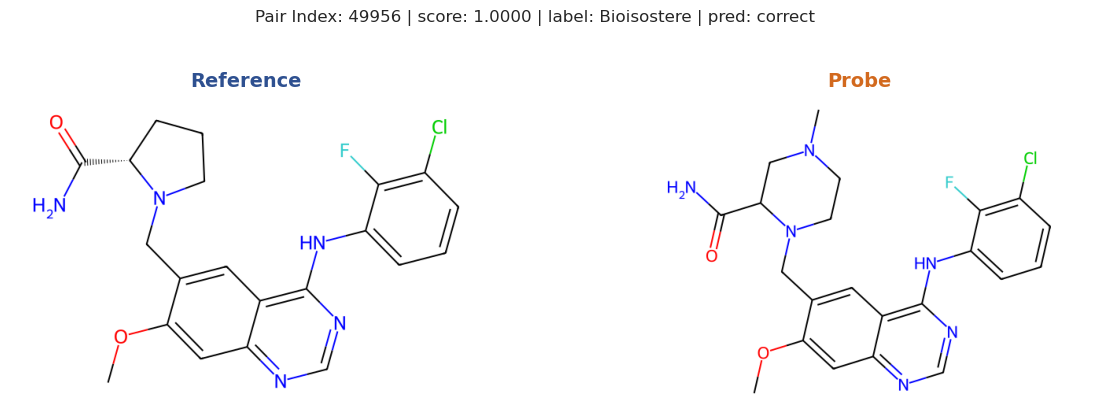

--------------------------------------------------------------------------------

ペア 2/15
  REF-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCC1C(N)=O...
  PRB-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCN(C)CC1C(N)=O...
  予測値: 1.0000
  正解ラベル: Bioisostere
  予測結果: 正解
  保存: structure_visualizations/target_pairs/pair_49990_structure.png
  保存: structure_visualizations/target_pairs/pair_49990_structure.png


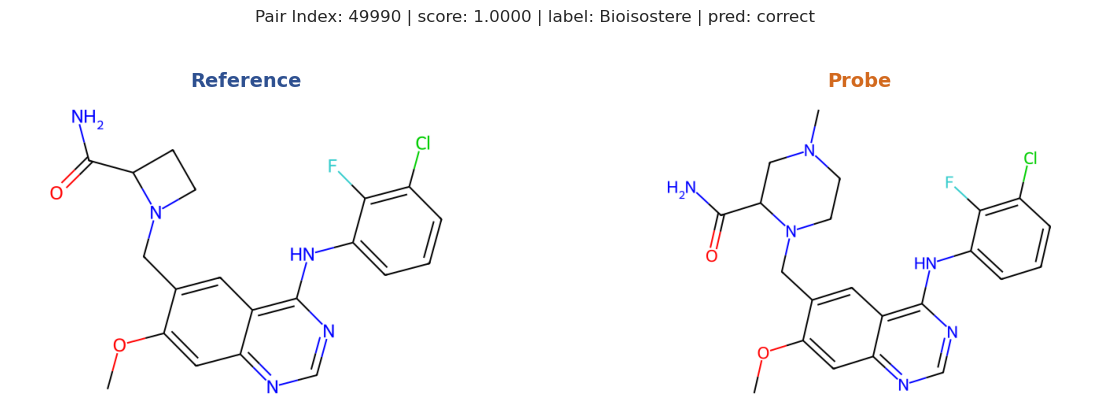

--------------------------------------------------------------------------------

ペア 3/15
  REF-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCC[C@@H]1C(N)=O...
  PRB-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCN(C)CC1C(N)=O...
  予測値: 1.0000
  正解ラベル: Bioisostere
  予測結果: 正解
  保存: structure_visualizations/target_pairs/pair_50000_structure.png
  保存: structure_visualizations/target_pairs/pair_50000_structure.png


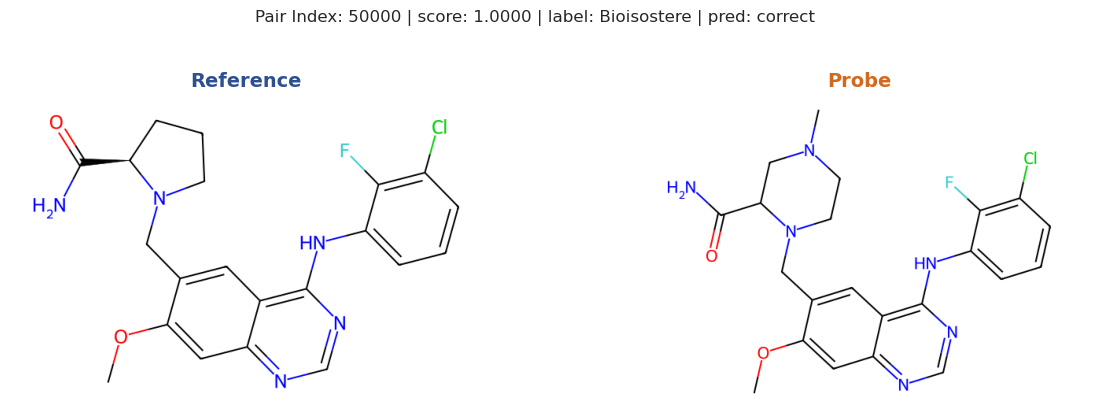

--------------------------------------------------------------------------------

ペア 4/15
  REF-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCC1C(N)=O...
  PRB-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCC[C@@H]1C(N)=O...
  予測値: 1.0000
  正解ラベル: Bioisostere
  予測結果: 正解
  保存: structure_visualizations/target_pairs/pair_49988_structure.png
  保存: structure_visualizations/target_pairs/pair_49988_structure.png


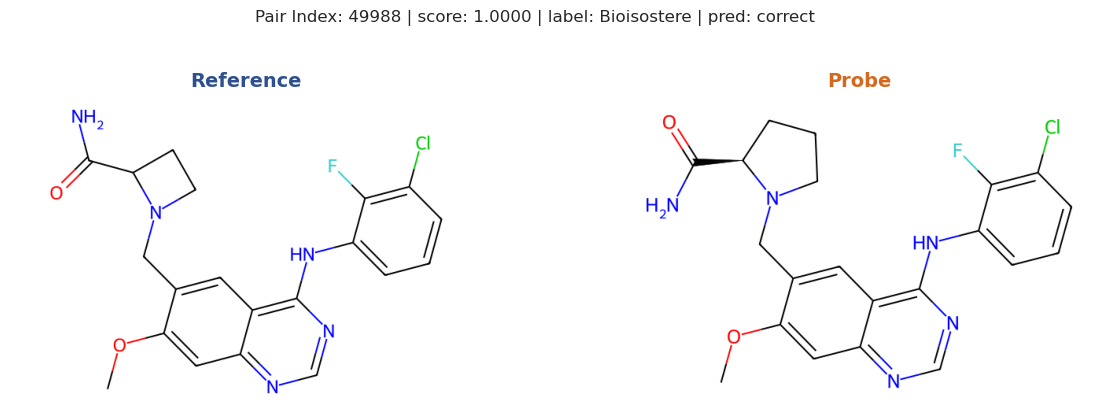

--------------------------------------------------------------------------------

ペア 5/15
  REF-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN(C)C1(C(N)=O)CN(C(C)C)C1...
  PRB-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCN(C)CC1C(N)=O...
  予測値: 1.0000
  正解ラベル: Bioisostere
  予測結果: 正解
  保存: structure_visualizations/target_pairs/pair_49966_structure.png
  保存: structure_visualizations/target_pairs/pair_49966_structure.png


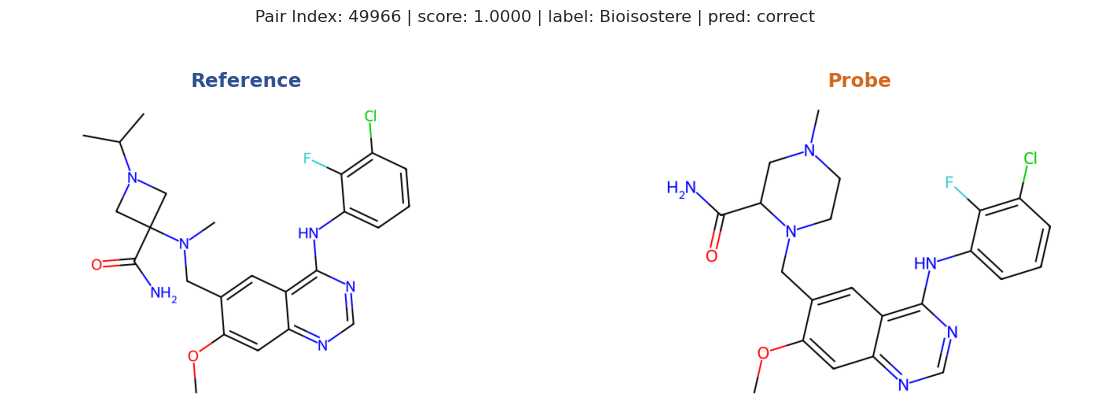

--------------------------------------------------------------------------------

ペア 6/15
  REF-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1C[C@H](OC)C[C@@H]1C(N)=O...
  PRB-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCC[C@@H]1C(N)=O...
  予測値: 1.0000
  正解ラベル: Bioisostere
  予測結果: 正解
  保存: structure_visualizations/target_pairs/pair_49977_structure.png
  保存: structure_visualizations/target_pairs/pair_49977_structure.png


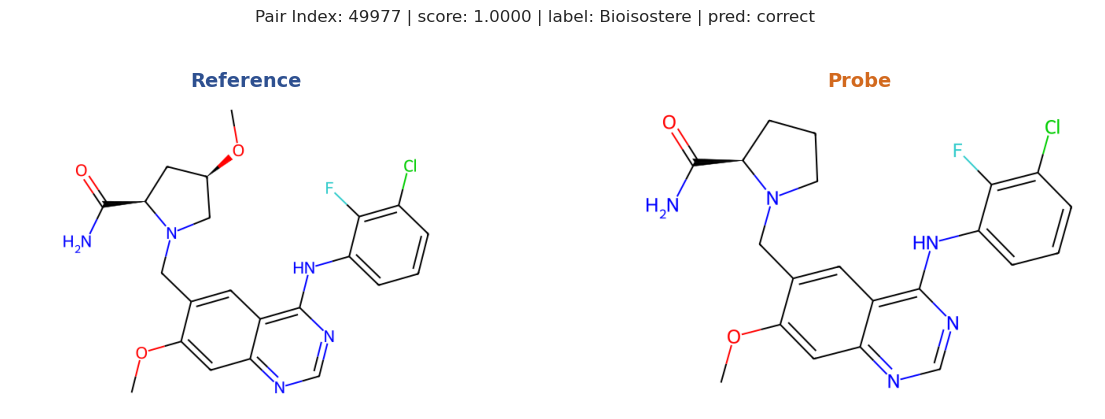

--------------------------------------------------------------------------------

ペア 7/15
  REF-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN(C)C1(C(N)=O)CN(C(C)C)C1...
  PRB-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCC1C(N)=O...
  予測値: 1.0000
  正解ラベル: Bioisostere
  予測結果: 正解
  保存: structure_visualizations/target_pairs/pair_49962_structure.png
  保存: structure_visualizations/target_pairs/pair_49962_structure.png


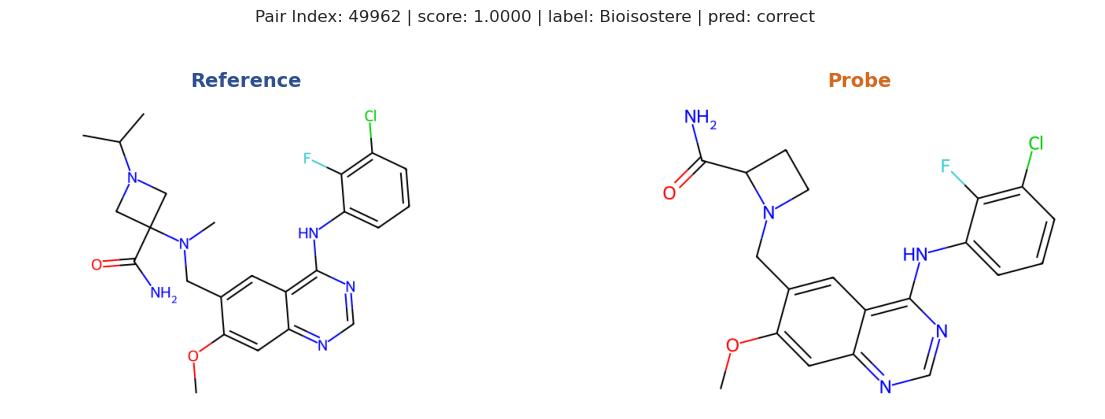

--------------------------------------------------------------------------------

ペア 8/15
  REF-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN(C)C1(C(N)=O)CN(C(C)C)C1...
  PRB-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCC[C@@H]1C(N)=O...
  予測値: 1.0000
  正解ラベル: Bioisostere
  予測結果: 正解
  保存: structure_visualizations/target_pairs/pair_49964_structure.png
  保存: structure_visualizations/target_pairs/pair_49964_structure.png


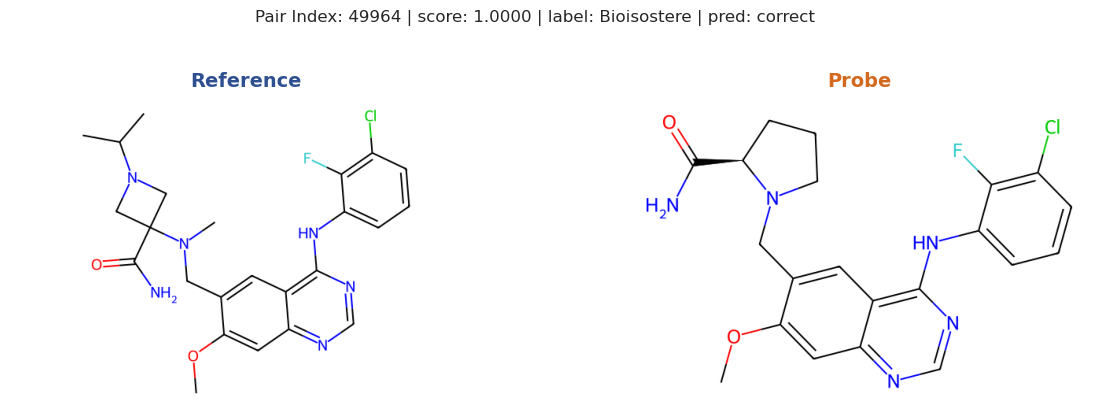

--------------------------------------------------------------------------------

ペア 9/15
  REF-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCCC[C@@H]1C(N)=O...
  PRB-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCN(C)CC1C(N)=O...
  予測値: 1.0000
  正解ラベル: Bioisostere
  予測結果: 正解
  保存: structure_visualizations/target_pairs/pair_49996_structure.png
  保存: structure_visualizations/target_pairs/pair_49996_structure.png


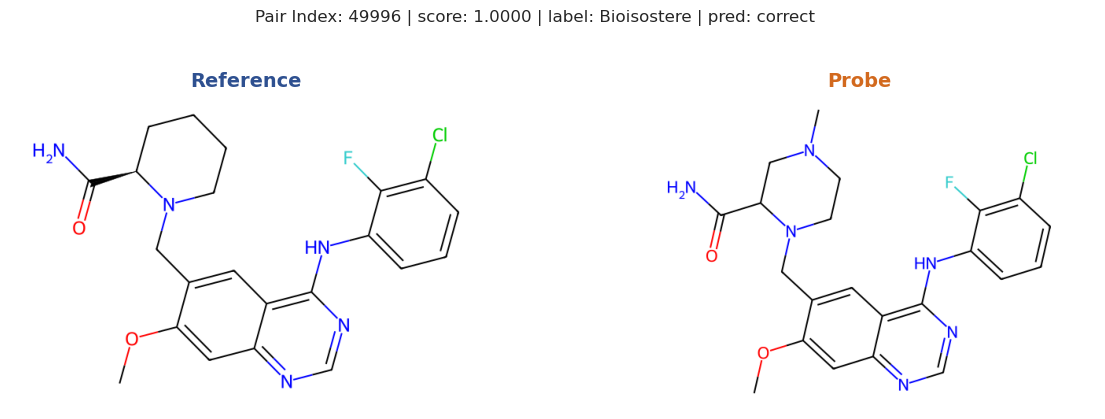

--------------------------------------------------------------------------------

ペア 10/15
  REF-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN(C)C1(C(N)=O)CN(C)C1...
  PRB-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCN(C)CC1C(N)=O...
  予測値: 1.0000
  正解ラベル: Bioisostere
  予測結果: 正解
  保存: structure_visualizations/target_pairs/pair_49904_structure.png
  保存: structure_visualizations/target_pairs/pair_49904_structure.png


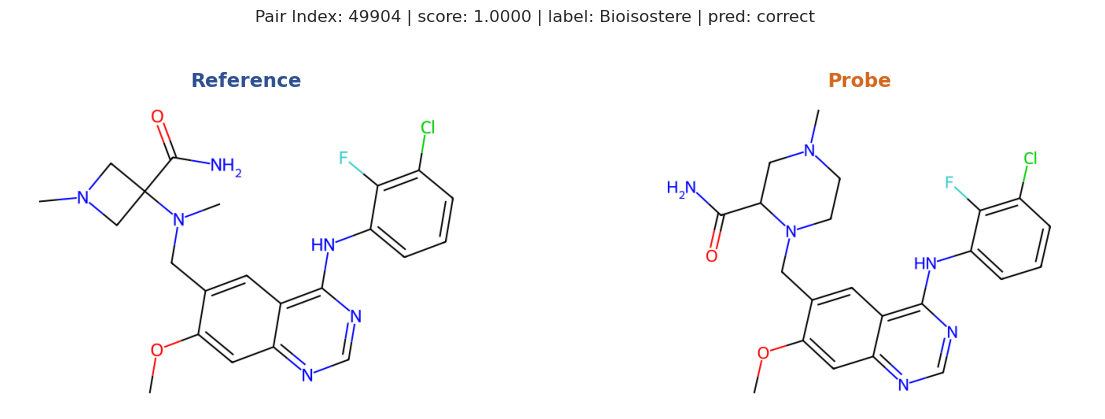

--------------------------------------------------------------------------------

ペア 11/15
  REF-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN(C)C1(C(N)=O)CN(C)C1...
  PRB-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCC[C@H]1C(N)=O...
  予測値: 1.0000
  正解ラベル: Bioisostere
  予測結果: 正解
  保存: structure_visualizations/target_pairs/pair_49899_structure.png
  保存: structure_visualizations/target_pairs/pair_49899_structure.png


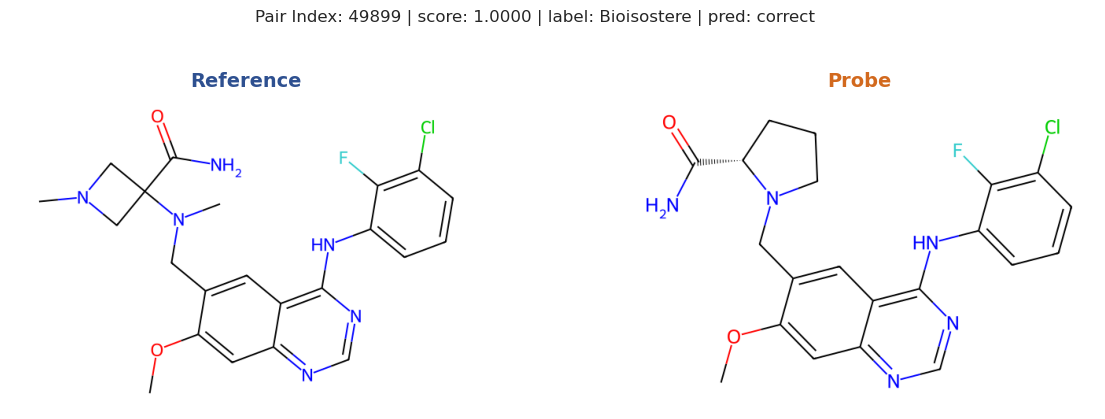

--------------------------------------------------------------------------------

ペア 12/15
  REF-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN(C)C1(C(N)=O)CN(C)C1...
  PRB-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCC[C@@H]1C(N)=O...
  予測値: 1.0000
  正解ラベル: Bioisostere
  予測結果: 正解
  保存: structure_visualizations/target_pairs/pair_49902_structure.png
  保存: structure_visualizations/target_pairs/pair_49902_structure.png


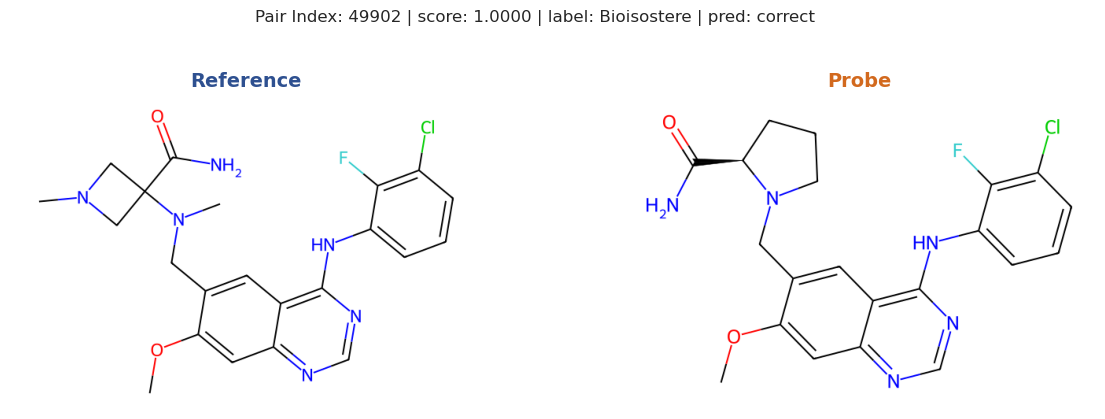

--------------------------------------------------------------------------------

ペア 13/15
  REF-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCCC[C@@H]1C(N)=O...
  PRB-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCC[C@@H]1C(N)=O...
  予測値: 1.0000
  正解ラベル: Bioisostere
  予測結果: 正解
  保存: structure_visualizations/target_pairs/pair_49994_structure.png
  保存: structure_visualizations/target_pairs/pair_49994_structure.png


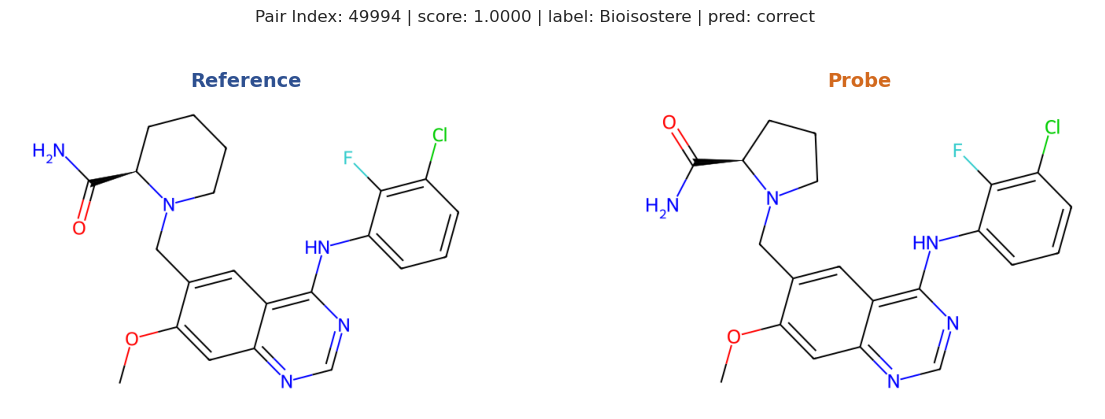

--------------------------------------------------------------------------------

ペア 14/15
  REF-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCN(C)CC1C(N)=O...
  PRB-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN(C)C1CCNC1=O...
  予測値: 1.0000
  正解ラベル: Bioisostere
  予測結果: 正解
  保存: structure_visualizations/target_pairs/pair_50005_structure.png
  保存: structure_visualizations/target_pairs/pair_50005_structure.png


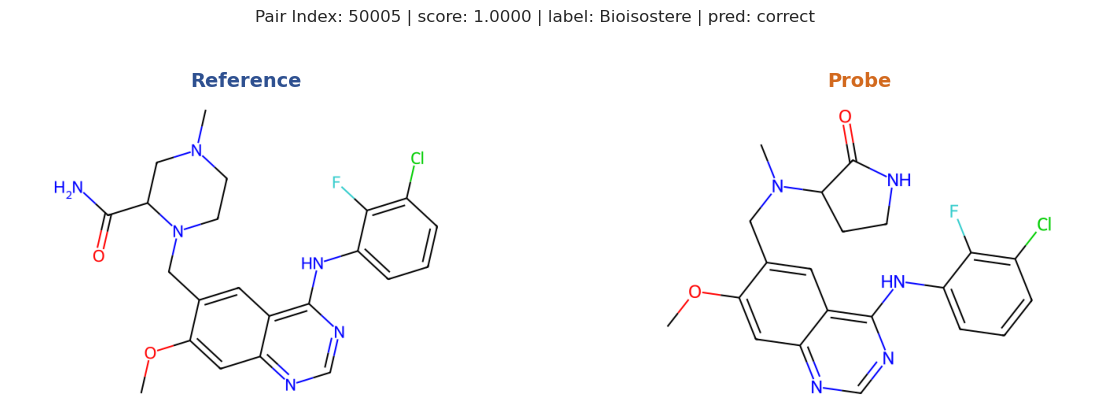

--------------------------------------------------------------------------------

ペア 15/15
  REF-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN(C)C1(C(N)=O)CN(C(C)C)C1...
  PRB-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1C[C@H](OC)C[C@@H]1C(N)=O...
  予測値: 1.0000
  正解ラベル: Bioisostere
  予測結果: 正解
  保存: structure_visualizations/target_pairs/pair_49961_structure.png
  保存: structure_visualizations/target_pairs/pair_49961_structure.png


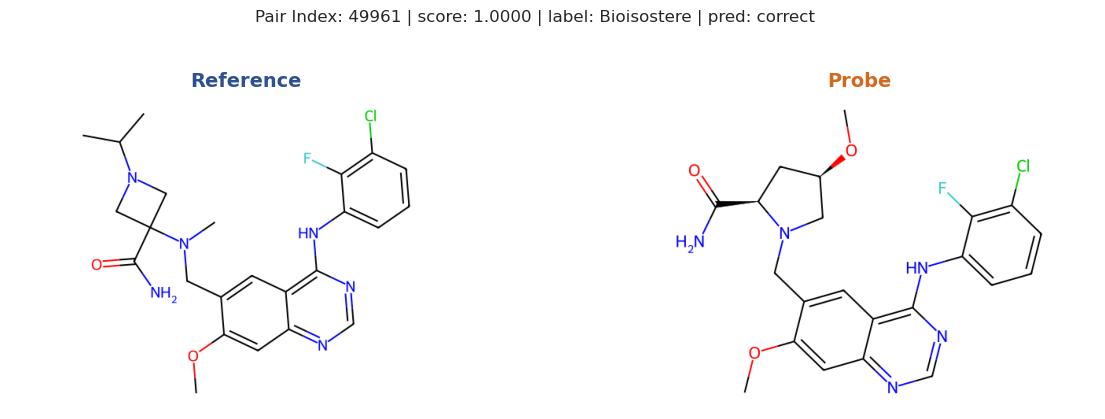

--------------------------------------------------------------------------------


In [ ]:
# === 条件1: 既存のtarget_pairs_with_smilesを可視化 ===
# すでに条件で絞り込まれたペア（N_PAIRS, LABEL_CONDITION, SORT_ORDERなどで指定）

if 'target_pairs_with_smiles' in dir() and len(target_pairs_with_smiles) > 0:
    print("既存の選択条件に基づくペアの可視化:")
    print(f"選択条件: N_PAIRS={N_PAIRS}, LABEL_CONDITION={LABEL_CONDITION}, SORT_ORDER={SORT_ORDER}")
    print(f"総ペア数: {len(target_pairs_with_smiles)}")
    
    # 最大5ペアを表示
    visualize_multiple_pairs(
        target_pairs_with_smiles, 
        max_pairs=15,
        save_dir='structure_visualizations/target_pairs'
    )
else:
    print("target_pairs_with_smilesが見つかりません。先に該当セクションを実行してください。")

### カスタム条件でのペア選択と可視化

新しい条件を指定してペアを選択・可視化できます。

カスタム条件でのペア選択:
  ラベル条件: Bioisostere
  正解条件: 正解のみ
  ソート: highest
  表示ペア数: 3

フィルタ後のペア数: 8968
可視化するペア数: 3

ペア 1/3
  REF-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCC[C@H]1C(N)=O...
  PRB-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCN(C)CC1C(N)=O...
  予測値: 1.0000
  正解ラベル: Bioisostere
  予測結果: 正解


/tmp/60209.1.interactive/ipykernel_681719/4135729675.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  保存: structure_visualizations/custom_selection/pair_49956_structure.png


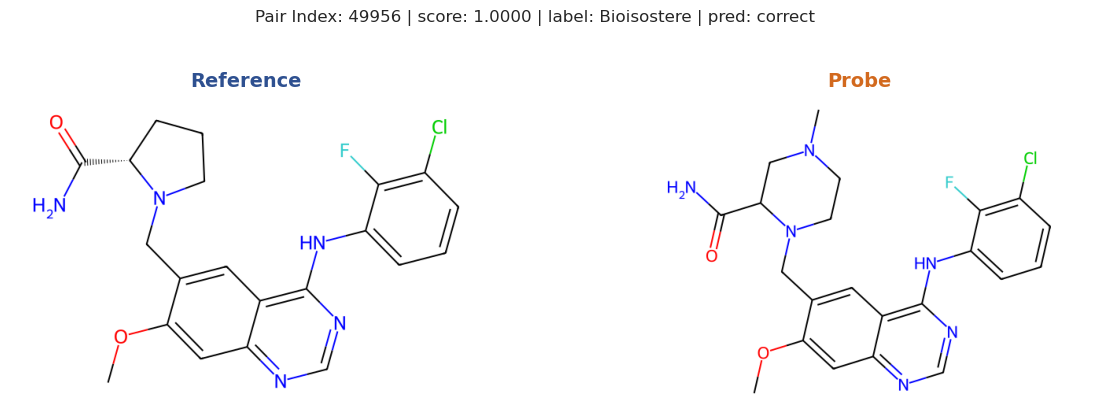

--------------------------------------------------------------------------------

ペア 2/3
  REF-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCC[C@@H]1C(N)=O...
  PRB-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCN(C)CC1C(N)=O...
  予測値: 1.0000
  正解ラベル: Bioisostere
  予測結果: 正解
  保存: structure_visualizations/custom_selection/pair_50000_structure.png
  保存: structure_visualizations/custom_selection/pair_50000_structure.png


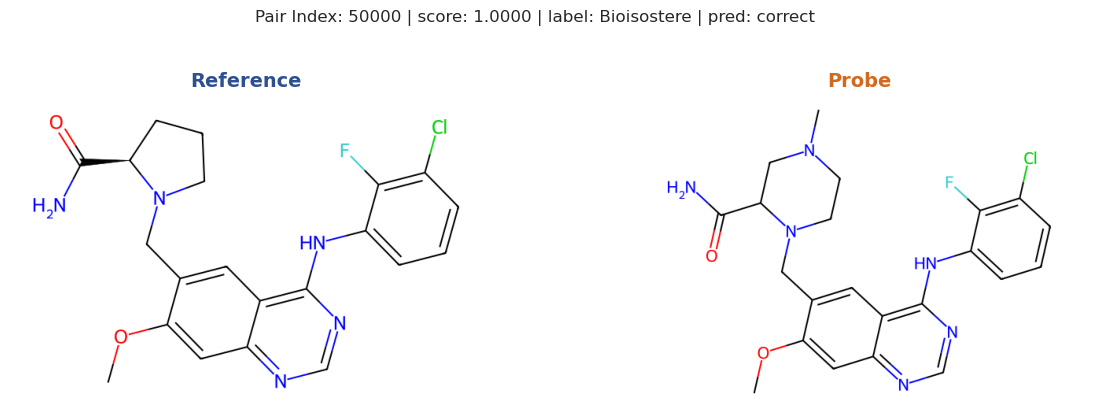

--------------------------------------------------------------------------------

ペア 3/3
  REF-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCC1C(N)=O...
  PRB-SMILES: COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCN(C)CC1C(N)=O...
  予測値: 1.0000
  正解ラベル: Bioisostere
  予測結果: 正解
  保存: structure_visualizations/custom_selection/pair_49990_structure.png
  保存: structure_visualizations/custom_selection/pair_49990_structure.png


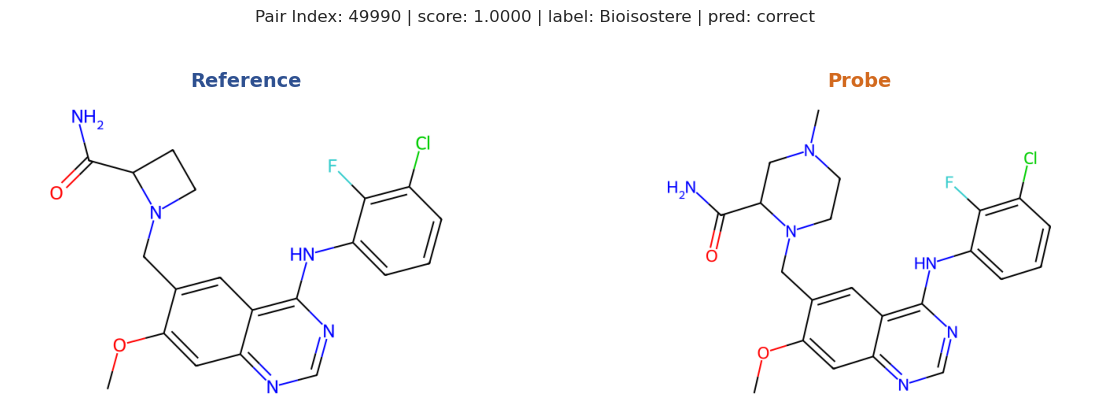

--------------------------------------------------------------------------------


In [ ]:
# === 条件2: 高予測値のBioisostereペアを可視化 ===

# カスタム条件の設定
CUSTOM_LABEL = 1  # 1: Bioisostere, 0: Non-Bioisostere, None: 両方
CUSTOM_CORRECT = True  # True: 正解のみ, False: 不正解のみ, None: 両方
CUSTOM_N_PAIRS = 3  # 表示するペア数
CUSTOM_SORT = 'highest'  # 'highest': 予測値降順, 'lowest': 予測値昇順

print(f"カスタム条件でのペア選択:")
print(f"  ラベル条件: {'Bioisostere' if CUSTOM_LABEL == 1 else 'Non-Bioisostere' if CUSTOM_LABEL == 0 else '全て'}")
print(f"  正解条件: {'正解のみ' if CUSTOM_CORRECT == True else '不正解のみ' if CUSTOM_CORRECT == False else '全て'}")
print(f"  ソート: {CUSTOM_SORT}")
print(f"  表示ペア数: {CUSTOM_N_PAIRS}")

# データの読み込み（まだ読み込んでいない場合）
if 'original_df' not in dir():
    ORIGINAL_CSV = '/home/8/uf02678/gsbsmasunaga/MMP_dataset/dataset_consistentsmiles.csv'
    original_df = pd.read_csv(ORIGINAL_CSV)
    print(f"\n元データを読み込みました: {len(original_df)} ペア")

# high_pred_dfを使用（既に実行されている前提）
if 'high_pred_df' in dir():
    custom_df = high_pred_df.copy()
    
    # 条件でフィルタリング
    if CUSTOM_LABEL is not None:
        custom_df = custom_df[custom_df['is_bioisostere'] == CUSTOM_LABEL]
    
    if CUSTOM_CORRECT is not None:
        custom_df = custom_df[custom_df['is_correct'] == CUSTOM_CORRECT]
    
    # ソート
    ascending = (CUSTOM_SORT == 'lowest')
    custom_df = custom_df.sort_values('pred_value', ascending=ascending)
    
    print(f"\nフィルタ後のペア数: {len(custom_df)}")
    
    if len(custom_df) > 0:
        # SMILES情報を追加
        custom_pairs = custom_df.head(CUSTOM_N_PAIRS).copy()
        
        for idx, row in custom_pairs.iterrows():
            pair_idx = int(row['pair_index'])
            if pair_idx < len(original_df):
                if 'REF-SMILES' in original_df.columns:
                    custom_pairs.loc[idx, 'ref_smiles'] = original_df.loc[pair_idx, 'REF-SMILES']
                    custom_pairs.loc[idx, 'prb_smiles'] = original_df.loc[pair_idx, 'PRB-SMILES']
                elif 'ref_smiles' in original_df.columns:
                    custom_pairs.loc[idx, 'ref_smiles'] = original_df.loc[pair_idx, 'ref_smiles']
                    custom_pairs.loc[idx, 'prb_smiles'] = original_df.loc[pair_idx, 'prb_smiles']
        
        # 可視化
        visualize_multiple_pairs(
            custom_pairs,
            max_pairs=CUSTOM_N_PAIRS,
            save_dir='structure_visualizations/custom_selection'
        )
    else:
        print("条件に合うペアが見つかりませんでした。")
else:
    print("high_pred_dfが見つかりません。先に該当セクションを実行してください。")

### 特定ペアインデックスの可視化

任意のペアインデックスを指定して個別に可視化します。

指定されたペアインデックス: [0, 10, 100]

可視化するペア数: 3
可視化するペア数: 3

ペア 1/3
  REF-SMILES: C#CCCCC(=O)c1cc(C(C)(C)C)c2c(c1)C(C)(C)CO2...
  PRB-SMILES: C#CCCCC(=O)c1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1...
  保存: structure_visualizations/specific_pairs/pair_0_structure.png


/tmp/60209.1.interactive/ipykernel_681719/4135729675.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


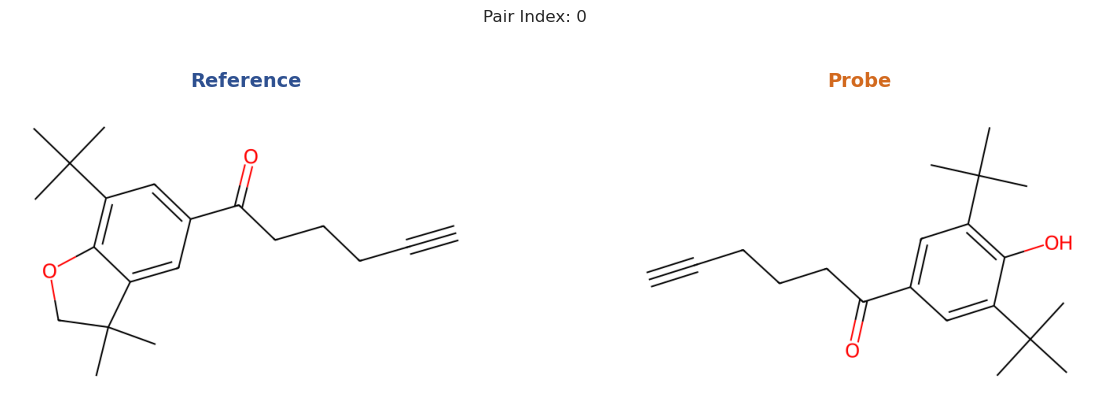

--------------------------------------------------------------------------------

ペア 2/3
  REF-SMILES: CCCN1CCC(c2cccnc2)C1...
  PRB-SMILES: CCCN1CCC(C2CCCCC2)C1...
  保存: structure_visualizations/specific_pairs/pair_10_structure.png


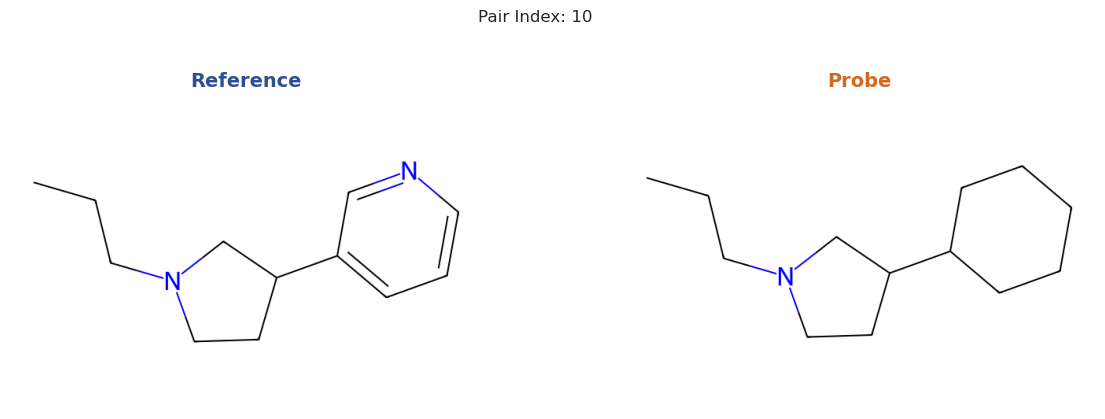

--------------------------------------------------------------------------------

ペア 3/3
  REF-SMILES: COc1cc(N)c(Cl)cc1C(=O)NC1CCN(CC2CCN(C(=O)C(N)C(C)C)CC2)CC1...
  PRB-SMILES: COc1cc(N)c(Cl)cc1C(=O)NC1CCN(CC2CCN(CC(C)CN)CC2)CC1...
  保存: structure_visualizations/specific_pairs/pair_100_structure.png


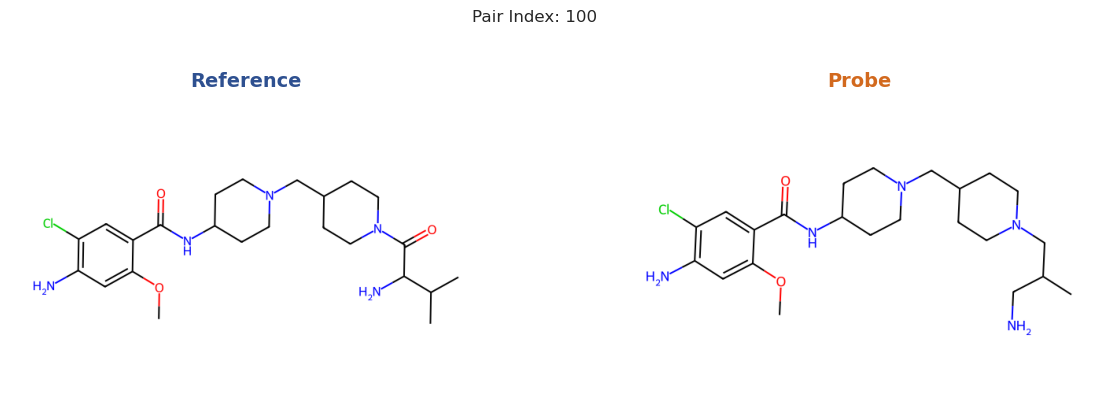

--------------------------------------------------------------------------------


In [ ]:
# === 条件3: 特定のペアインデックスを可視化 ===

# 可視化したいペアのインデックスを指定（リスト形式）
SPECIFIC_PAIR_INDICES = [0, 10, 100]  # 例: 0番目、10番目、100番目のペア

print(f"指定されたペアインデックス: {SPECIFIC_PAIR_INDICES}")

# データの読み込み（まだ読み込んでいない場合）
if 'original_df' not in dir():
    ORIGINAL_CSV = '/home/8/uf02678/gsbsmasunaga/MMP_dataset/dataset_consistentsmiles.csv'
    original_df = pd.read_csv(ORIGINAL_CSV)

# 指定されたペアのデータを取得
specific_pairs_list = []

for pair_idx in SPECIFIC_PAIR_INDICES:
    if pair_idx < len(original_df):
        row_data = original_df.iloc[pair_idx]
        
        # SMILESを取得
        if 'REF-SMILES' in original_df.columns:
            ref_smiles = row_data['REF-SMILES']
            prb_smiles = row_data['PRB-SMILES']
        elif 'ref_smiles' in original_df.columns:
            ref_smiles = row_data['ref_smiles']
            prb_smiles = row_data['prb_smiles']
        else:
            print(f"Warning: SMILESカラムが見つかりません")
            continue
        
        # ペア情報を作成
        pair_info = {
            'pair_index': pair_idx,
            'ref_smiles': ref_smiles,
            'prb_smiles': prb_smiles
        }
        
        # 予測値情報がある場合は追加
        if 'high_pred_df' in dir():
            matching_pred = high_pred_df[high_pred_df['pair_index'] == pair_idx]
            if len(matching_pred) > 0:
                pred_row = matching_pred.iloc[0]
                pair_info['pred_value'] = pred_row['pred_value']
                pair_info['is_bioisostere'] = pred_row['is_bioisostere']
                pair_info['is_correct'] = pred_row['is_correct']
        
        specific_pairs_list.append(pair_info)
    else:
        print(f"Warning: ペアインデックス {pair_idx} はデータ範囲外です（最大: {len(original_df)-1}）")

if specific_pairs_list:
    specific_pairs_df = pd.DataFrame(specific_pairs_list)
    print(f"\n可視化するペア数: {len(specific_pairs_df)}")
    
    # 可視化
    visualize_multiple_pairs(
        specific_pairs_df,
        max_pairs=len(specific_pairs_df),
        save_dir='structure_visualizations/specific_pairs'
    )
else:
    print("可視化できるペアがありません。")

### 予測ミスのケース分析

Bioisostereを誤ってNon-Bioisostereと予測したケース、またはその逆のケースを可視化します。

In [ ]:
# === 条件4: 予測ミスのケースを可視化 ===

ERROR_TYPE = 'false_negative'  # 'false_negative': Bioisostereを見逃し, 'false_positive': 誤って予測
ERROR_N_PAIRS = 3  # 表示するペア数

print(f"予測ミスのケース分析:")
print(f"  エラータイプ: {ERROR_TYPE}")
print(f"  表示ペア数: {ERROR_N_PAIRS}")

if 'high_pred_df' in dir():
    if ERROR_TYPE == 'false_negative':
        # Bioisostereなのに低予測値（見逃し）
        error_df = high_pred_df[
            (high_pred_df['is_bioisostere'] == 1) & 
            (high_pred_df['is_correct'] == False)
        ].sort_values('pred_value', ascending=True)  # 予測値が低い順
        error_label = "False Negative (Bioisostereの見逃し)"
        
    elif ERROR_TYPE == 'false_positive':
        # Non-Bioisostereなのに高予測値（誤検出）
        error_df = high_pred_df[
            (high_pred_df['is_bioisostere'] == 0) & 
            (high_pred_df['is_correct'] == False)
        ].sort_values('pred_value', ascending=False)  # 予測値が高い順
        error_label = "False Positive (Non-Bioisostereの誤検出)"
    else:
        print(f"エラータイプ '{ERROR_TYPE}' は無効です。")
        error_df = pd.DataFrame()
    
    print(f"\n{error_label}のケース数: {len(error_df)}")
    
    if len(error_df) > 0:
        # データの読み込み
        if 'original_df' not in dir():
            ORIGINAL_CSV = '/home/8/uf02678/gsbsmasunaga/MMP_dataset/dataset_consistentsmiles.csv'
            original_df = pd.read_csv(ORIGINAL_CSV)
        
        # SMILES情報を追加
        error_pairs = error_df.head(ERROR_N_PAIRS).copy()
        
        for idx, row in error_pairs.iterrows():
            pair_idx = int(row['pair_index'])
            if pair_idx < len(original_df):
                if 'REF-SMILES' in original_df.columns:
                    error_pairs.loc[idx, 'ref_smiles'] = original_df.loc[pair_idx, 'REF-SMILES']
                    error_pairs.loc[idx, 'prb_smiles'] = original_df.loc[pair_idx, 'PRB-SMILES']
                elif 'ref_smiles' in original_df.columns:
                    error_pairs.loc[idx, 'ref_smiles'] = original_df.loc[pair_idx, 'ref_smiles']
                    error_pairs.loc[idx, 'prb_smiles'] = original_df.loc[pair_idx, 'prb_smiles']
        
        # 可視化
        print(f"\n{error_label}のケースを可視化:")
        visualize_multiple_pairs(
            error_pairs,
            max_pairs=ERROR_N_PAIRS,
            save_dir=f'structure_visualizations/{ERROR_TYPE}'
        )
    else:
        print("該当するエラーケースが見つかりませんでした。")
else:
    print("high_pred_dfが見つかりません。先に該当セクションを実行してください。")

予測ミスのケース分析:
  エラータイプ: false_negative
  表示ペア数: 3

False Negative (Bioisostereの見逃し)のケース数: 0
該当するエラーケースが見つかりませんでした。


### 一括可視化の概要

可視化したペアの一覧を表示します。

In [ ]:
# 保存された画像ファイルの確認
import os
import glob

base_dir = 'structure_visualizations'

if os.path.exists(base_dir):
    print("保存された構造式画像:")
    print("="*80)
    
    subdirs = ['target_pairs', 'custom_selection', 'specific_pairs', 'false_negative', 'false_positive']
    
    total_images = 0
    for subdir in subdirs:
        subdir_path = os.path.join(base_dir, subdir)
        if os.path.exists(subdir_path):
            images = glob.glob(os.path.join(subdir_path, '*.png'))
            if images:
                print(f"\n{subdir}:")
                print(f"  画像数: {len(images)}")
                for img in sorted(images)[:5]:  # 最初の5つを表示
                    print(f"    - {os.path.basename(img)}")
                if len(images) > 5:
                    print(f"    ... 他 {len(images)-5} 件")
                total_images += len(images)
    
    print(f"\n総画像数: {total_images}")
    print(f"保存先ディレクトリ: {os.path.abspath(base_dir)}")
else:
    print(f"画像保存ディレクトリ '{base_dir}' が見つかりません。")
    print("上記のセルを実行して構造式を可視化してください。")

保存された構造式画像:

target_pairs:
  画像数: 5
    - pair_49956_structure.png
    - pair_49966_structure.png
    - pair_49988_structure.png
    - pair_49990_structure.png
    - pair_50000_structure.png

custom_selection:
  画像数: 3
    - pair_49956_structure.png
    - pair_49990_structure.png
    - pair_50000_structure.png

specific_pairs:
  画像数: 3
    - pair_0_structure.png
    - pair_100_structure.png
    - pair_10_structure.png

総画像数: 11
保存先ディレクトリ: /gs/bs/tga-ohuelab/masunaga/bioiso/pro_GNN/analysis/structure_visualizations
